# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics
We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to recover the primitive pressure from the conserved variables.

Use this first cell to convert this notebook to a python script.

In [ ]:
%%script echo skipping

!jupyter nbconvert pt7.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on google colab,

In [ ]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Constants and flags to set
Defining some constants and parameters for convenience.

In [ ]:

N_TRIALS = 200 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..

# I try out here the values as obtained in Optuna run 5, but I will increase the number of epochs.
# N_LAYERS_NO_OPT = 3
# N_UNITS_NO_OPT = [78, 193, 99]
# HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
# OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
# LOSS_NAME_NO_OPT = "MSE"
# OPTIMIZER_NAME_NO_OPT = "Adam"
# LR_NO_OPT = 0.00036516467819506355
# BATCH_SIZE_NO_OPT = 170
# N_EPOCHS_NO_OPT = 400
# SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

# Dieselhorst hyperparameters
N_LAYERS_NO_OPT = 2
N_UNITS_NO_OPT = [600, 200]
HIDDEN_ACTIVATION_NAME_NO_OPT = "Sigmoid"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "MSE"
OPTIMIZER_NAME_NO_OPT = "Adam"
LR_NO_OPT = 6e-3
BATCH_SIZE_NO_OPT = 32
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"


c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, 0.721 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(6) # Uncomment for pseudorandom data.

## Generating the data

In [ ]:

# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon


# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, epsilon


# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    W = 1 / torch.sqrt(1 - vx ** 2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, tau = compute_conserved_variables(rho, vx, epsilon)

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p

Sampling the primitive variables using the sample_primitive_variables function

In [ ]:
rho_train, vx_train, epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test, epsilon_test = sample_primitive_variables(n_test_samples)


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

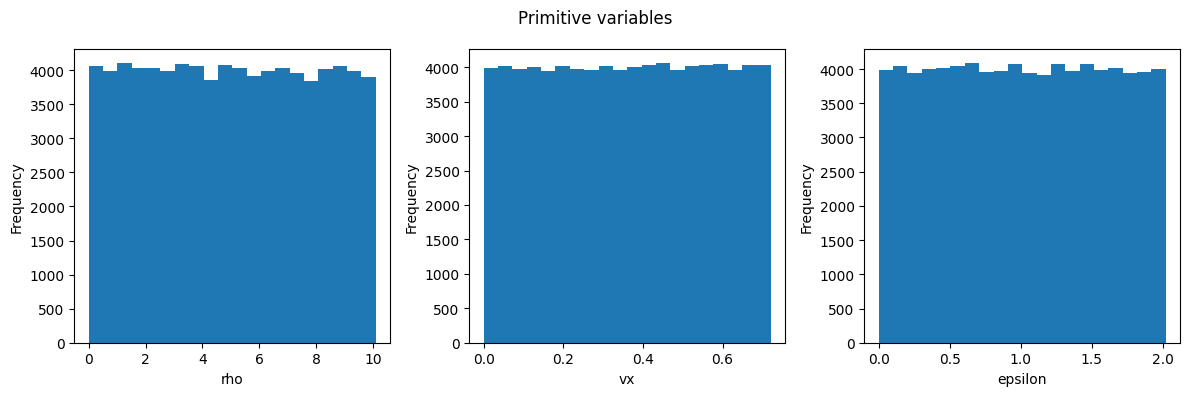

In [ ]:
# Plotting the histograms of rho, vx and epsilon
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(rho_train, bins=20)
plt.xlabel("rho")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(vx_train, bins=20)
plt.xlabel("vx")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(epsilon_train, bins=20)
plt.xlabel("epsilon")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.suptitle("Primitive variables")
plt.tight_layout()
plt.show()



In [ ]:

# Generating the input and output data for train and test sets.
x_train = generate_input_data(rho_train, vx_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, epsilon_test) 
y_test = generate_labels(rho_test, epsilon_test) 


tensor([4.6096, 1.4171, 8.6229,  ..., 0.2828, 0.1102, 6.0296], device='cuda:0')

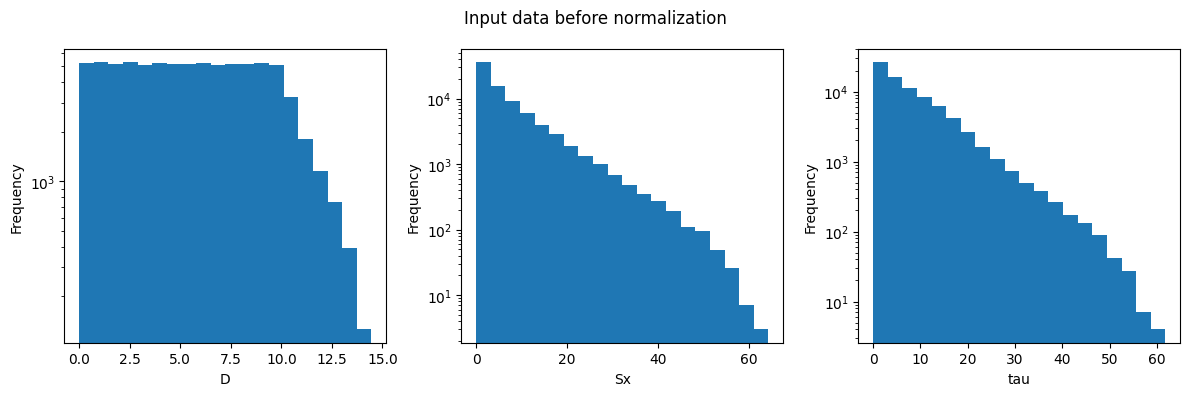

In [ ]:
# Plotting the histograms of the input data before normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data before normalization")
plt.tight_layout()
plt.show()


Perform z-score normalization

In [ ]:

# Computing the mean and standard deviation of each input variable from the training set
D_mean = torch.mean(x_train[:, 0])
D_std = torch.std(x_train[:, 0])
Sx_mean = torch.mean(x_train[:, 1])
Sx_std = torch.std(x_train[:, 1])
tau_mean = torch.mean(x_train[:, 2])
tau_std = torch.std(x_train[:, 2])

# Applying z-score normalization to both train and test sets using the statistics from the training set
x_train[:, 0] = torch.sub(x_train[:, 0], D_mean).div(D_std)
x_train[:, 1] = torch.sub(x_train[:, 1], Sx_mean).div(Sx_std)
x_train[:, 2] = torch.sub(x_train[:, 2], tau_mean).div(tau_std)
x_test[:, 0] = torch.sub(x_test[:, 0], D_mean).div(D_std)
x_test[:, 1] = torch.sub(x_test[:, 1], Sx_mean).div(Sx_std)
x_test[:, 2] = torch.sub(x_test[:, 2], tau_mean).div(tau_std)


tensor(7.3147e-08, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.1539e-07, device='cuda:0')
tensor(1., device='cuda:0')
tensor(4.9019e-08, device='cuda:0')
tensor(1.0000, device='cuda:0')


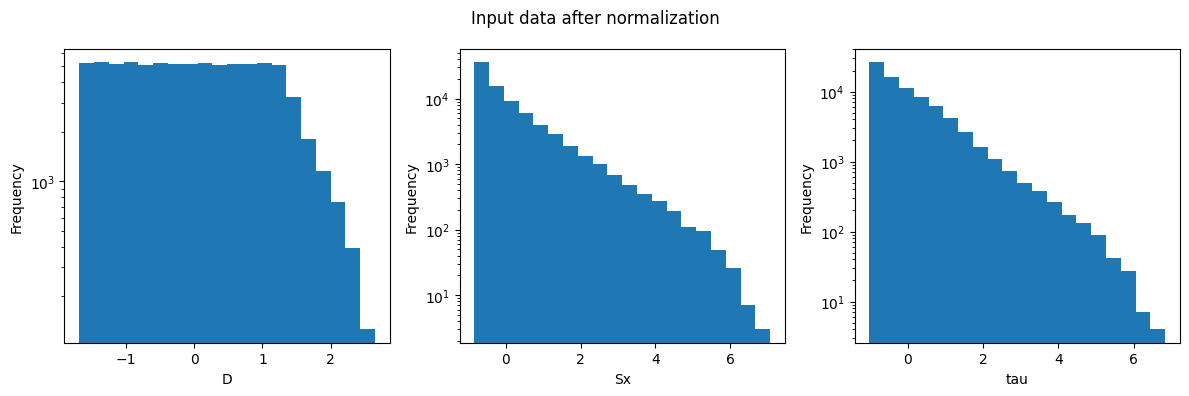

In [ ]:

# Verifying that the means and the stds of the input data are close to 0 and 1 respectively.
print(torch.mean(x_train[:, 0]))
print(torch.std(x_train[:, 0]))
print(torch.mean(x_train[:, 1]))
print(torch.std(x_train[:, 1]))
print(torch.mean(x_train[:, 2]))
print(torch.std(x_train[:, 2]))

# Plotting the histograms of the input data after normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data after normalization")
plt.tight_layout()
plt.show()


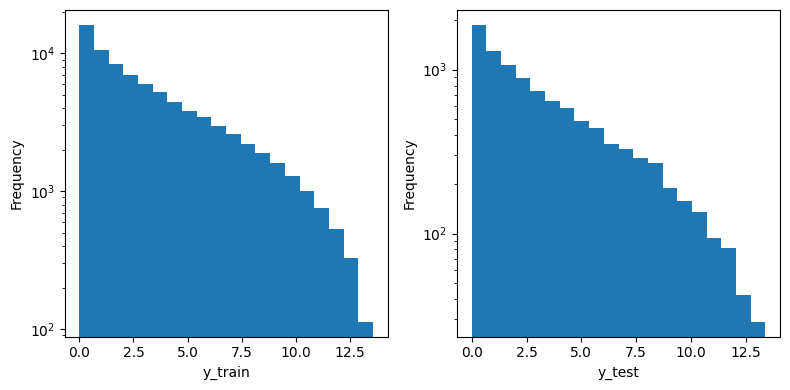

In [ ]:
# Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x

## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 1, 3)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 1048) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            "output_activation", ["ReLU", "Softplus"]
        ) 
        loss_name = trial.suggest_categorical(
            "loss", ["MSE", "MAE", "Huber", "LogCosh"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
        batch_size = trial.suggest_int("batch_size", 16, 256)
        n_epochs = trial.suggest_int("n_epochs", 10, 200) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR","OneCycleLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    # Creating the optimizer from its name
    if optimizer_name == "SGD":
        # Added sampling the weight decay and momentum for SGD
        weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
        momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
        optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    elif optimizer_name == "Adam":
        # Added sampling the weight decay and beta parameters for Adam
        weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
        beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
        beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=lr)
    else:
        # Added creating the Adagrad optimizer
        optimizer = optim.Adagrad(net.parameters(), lr=lr)

    # Creating the learning rate scheduler from its name
    if scheduler_name == "StepLR":
        # Added sampling the step_size and gamma for StepLR
        step_size = trial.suggest_int("step_size", 5, 15)
        gamma = trial.suggest_uniform("gamma", 0.05, 0.5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name == "ExponentialLR":
        # Added sampling the gamma for ExponentialLR
        gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_name == "CosineAnnealingLR":
        # Added sampling the T_max for CosineAnnealingLR
        T_max = trial.suggest_int("T_max", 5, 15)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
    elif scheduler_name == "ReduceLROnPlateau":
        # Added sampling the factor, patience and threshold for ReduceLROnPlateau
        factor = trial.suggest_uniform("factor", 0.1, 0.9)
        patience = trial.suggest_int("patience", 5, 15)
        threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
        )
    # # Added using OneCycleLR scheduler as an option
    # elif scheduler_name == "OneCycleLR":
    #         # Added sampling the max_lr and pct_start for OneCycleLR
    #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
    #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
    #         scheduler = optim.lr_scheduler.OneCycleLR(
    #             optimizer,
    #             max_lr=max_lr,
    #             epochs=n_epochs,
    #             steps_per_epoch=len(train_loader),
    #             pct_start=pct_start,
    #         )
    else:
        scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-14 11:41:14,159] A new study created in memory with name: no-name-a4052879-bff0-437a-90f1-14dccfeacacb
<ipython-input-68-d4ca07a22bfc>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
<ipython-input-68-d4ca07a22bfc>:117: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-68-d4ca07a22bfc>:118: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  bet

Epoch 1: Train Loss: 0.8697, Test Loss: 0.3775, Train L1 Norm: 15.6703, Test L1 Norm: 3.8680, Train Linf Norm: 2359.6604, Test Linf Norm: 433.2451
Epoch 2: Train Loss: 0.1448, Test Loss: 0.0941, Train L1 Norm: 5.1690, Test L1 Norm: 2.4258, Train Linf Norm: 733.6520, Test Linf Norm: 285.7900
Epoch 3: Train Loss: 0.0875, Test Loss: 0.0847, Train L1 Norm: 4.4336, Test L1 Norm: 2.3410, Train Linf Norm: 641.3397, Test Linf Norm: 276.3718
Epoch 4: Train Loss: 0.0790, Test Loss: 0.0768, Train L1 Norm: 4.2537, Test L1 Norm: 2.3018, Train Linf Norm: 618.7766, Test Linf Norm: 271.7662
Epoch 5: Train Loss: 0.0712, Test Loss: 0.0702, Train L1 Norm: 4.1381, Test L1 Norm: 2.3764, Train Linf Norm: 600.4698, Test Linf Norm: 280.8717
Epoch 6: Train Loss: 0.0642, Test Loss: 0.0621, Train L1 Norm: 4.0296, Test L1 Norm: 2.1886, Train Linf Norm: 578.8466, Test Linf Norm: 259.6838
Epoch 7: Train Loss: 0.0569, Test Loss: 0.0549, Train L1 Norm: 3.9088, Test L1 Norm: 2.2494, Train Linf Norm: 560.7675, Test Lin

[I 2023-05-14 11:45:23,339] Trial 0 finished with value: 1.4458721339672804 and parameters: {'n_layers': 1, 'n_units_0': 302, 'hidden_activation': 'Sigmoid', 'output_activation': 'Softplus', 'loss': 'LogCosh', 'optimizer': 'Adam', 'lr': 0.0006261315610903039, 'batch_size': 179, 'n_epochs': 176, 'scheduler': 'OneCycleLR', 'weight_decay': 0.00027673860329124086, 'beta1': 0.9422246337373985, 'beta2': 0.9113863105471367}. Best is trial 0 with value: 1.4458721339672804.


Epoch 176: Train Loss: 0.0067, Test Loss: 0.0065, Train L1 Norm: 2.5517, Test L1 Norm: 1.4459, Train Linf Norm: 362.1907, Test Linf Norm: 174.5431


<ipython-input-68-d4ca07a22bfc>:143: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.9)
<ipython-input-68-d4ca07a22bfc>:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


Epoch 1: Train Loss: 0.0703, Test Loss: 0.0376, Train L1 Norm: 2.6116, Test L1 Norm: 0.8582, Train Linf Norm: 458.6537, Test Linf Norm: 122.1459
Epoch 2: Train Loss: 0.0157, Test Loss: 0.0125, Train L1 Norm: 1.6652, Test L1 Norm: 0.7283, Train Linf Norm: 297.0647, Test Linf Norm: 105.7991
Epoch 3: Train Loss: 0.0101, Test Loss: 0.0106, Train L1 Norm: 1.5442, Test L1 Norm: 0.6440, Train Linf Norm: 291.1345, Test Linf Norm: 97.0599
Epoch 4: Train Loss: 0.0072, Test Loss: 0.0073, Train L1 Norm: 1.2411, Test L1 Norm: 0.7578, Train Linf Norm: 225.5264, Test Linf Norm: 116.2543
Epoch 5: Train Loss: 0.0063, Test Loss: 0.0014, Train L1 Norm: 1.2069, Test L1 Norm: 0.7247, Train Linf Norm: 221.2160, Test Linf Norm: 112.8428
Epoch 6: Train Loss: 0.0057, Test Loss: 0.0021, Train L1 Norm: 1.1893, Test L1 Norm: 0.5975, Train Linf Norm: 218.6265, Test Linf Norm: 91.3323
Epoch 7: Train Loss: 0.0053, Test Loss: 0.0039, Train L1 Norm: 1.2992, Test L1 Norm: 0.7991, Train Linf Norm: 245.8670, Test Linf No

[I 2023-05-14 11:47:25,720] Trial 1 finished with value: 0.518548201777041 and parameters: {'n_layers': 2, 'n_units_0': 968, 'n_units_1': 698, 'hidden_activation': 'ELU', 'output_activation': 'Softplus', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.0007597337238442713, 'batch_size': 231, 'n_epochs': 88, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 2.0291855117165224e-05, 'beta1': 0.5285938900134506, 'beta2': 0.9365822254554464, 'factor': 0.6471878218802753, 'patience': 11, 'threshold': 0.00032391499792754476}. Best is trial 1 with value: 0.518548201777041.


Epoch 88: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.9551, Test L1 Norm: 0.5185, Train Linf Norm: 181.7997, Test Linf Norm: 82.1014
Epoch 1: Train Loss: 0.1593, Test Loss: 0.0229, Train L1 Norm: 0.6938, Test L1 Norm: 0.5168, Train Linf Norm: 47.7451, Test Linf Norm: 37.8981
Epoch 2: Train Loss: 0.0382, Test Loss: 0.0172, Train L1 Norm: 0.3371, Test L1 Norm: 0.1441, Train Linf Norm: 20.9411, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.0322, Test Loss: 0.0083, Train L1 Norm: 0.2018, Test L1 Norm: 0.1246, Train Linf Norm: 9.4049, Test Linf Norm: 5.0589
Epoch 4: Train Loss: 0.0349, Test Loss: 0.0052, Train L1 Norm: 0.1589, Test L1 Norm: 0.1026, Train Linf Norm: 5.2758, Test Linf Norm: 2.5768
Epoch 5: Train Loss: 0.0371, Test Loss: 0.0039, Train L1 Norm: 0.5939, Test L1 Norm: 0.0782, Train Linf Norm: 52.3432, Test Linf Norm: 1.4200
Epoch 6: Train Loss: 0.0209, Test Loss: 0.0081, Train L1 Norm: 0.1768, Test L1 Norm: 0.1111, Train Linf Norm: 9.2220, Test Linf Norm: 1.0768
Epoch

[I 2023-05-14 11:53:03,962] Trial 2 finished with value: 0.045107196598500016 and parameters: {'n_layers': 1, 'n_units_0': 959, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.009818936028823444, 'batch_size': 109, 'n_epochs': 200, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 2.475799175274077e-05, 'beta1': 0.6298792165959769, 'beta2': 0.9887044337596589, 'factor': 0.8089219434659248, 'patience': 5, 'threshold': 0.005504551506575495}. Best is trial 2 with value: 0.045107196598500016.


Epoch 200: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0471, Test L1 Norm: 0.0451, Train Linf Norm: 1.7369, Test Linf Norm: 1.8426
Epoch 1: Train Loss: 0.6485, Test Loss: 0.1165, Train L1 Norm: 3.9067, Test L1 Norm: 1.4380, Train Linf Norm: 422.8199, Test Linf Norm: 141.5842
Epoch 2: Train Loss: 0.0807, Test Loss: 0.0567, Train L1 Norm: 2.2931, Test L1 Norm: 1.1207, Train Linf Norm: 273.1309, Test Linf Norm: 111.8245
Epoch 3: Train Loss: 0.0484, Test Loss: 0.0377, Train L1 Norm: 1.7659, Test L1 Norm: 0.9915, Train Linf Norm: 206.8467, Test Linf Norm: 100.1086
Epoch 4: Train Loss: 0.0355, Test Loss: 0.0300, Train L1 Norm: 1.5333, Test L1 Norm: 0.8703, Train Linf Norm: 179.5907, Test Linf Norm: 88.7265
Epoch 5: Train Loss: 0.0290, Test Loss: 0.0263, Train L1 Norm: 1.4223, Test L1 Norm: 0.8037, Train Linf Norm: 169.8088, Test Linf Norm: 82.3620
Epoch 6: Train Loss: 0.0253, Test Loss: 0.0223, Train L1 Norm: 1.3324, Test L1 Norm: 0.7822, Train Linf Norm: 158.9534, Test Linf Norm

[I 2023-05-14 11:54:11,050] Trial 3 finished with value: 0.6179802250981331 and parameters: {'n_layers': 1, 'n_units_0': 685, 'hidden_activation': 'ReLU', 'output_activation': 'Softplus', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00034439275716808827, 'batch_size': 144, 'n_epochs': 46, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 0.0007505900013800237, 'beta1': 0.588315742578141, 'beta2': 0.995395925005042, 'T_max': 9}. Best is trial 2 with value: 0.045107196598500016.


Epoch 46: Train Loss: 0.0128, Test Loss: 0.0121, Train L1 Norm: 1.0871, Test L1 Norm: 0.6180, Train Linf Norm: 133.5305, Test Linf Norm: 64.9225


<ipython-input-68-d4ca07a22bfc>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.8, 0.99)


Epoch 1: Train Loss: 0.4181, Test Loss: 0.1236, Train L1 Norm: 5.6263, Test L1 Norm: 2.8327, Train Linf Norm: 360.4695, Test Linf Norm: 169.5103
Epoch 2: Train Loss: 0.1076, Test Loss: 0.0989, Train L1 Norm: 4.9534, Test L1 Norm: 2.6498, Train Linf Norm: 328.1475, Test Linf Norm: 158.5419
Epoch 3: Train Loss: 0.0896, Test Loss: 0.0787, Train L1 Norm: 4.9692, Test L1 Norm: 2.6356, Train Linf Norm: 339.2752, Test Linf Norm: 157.7081
Epoch 4: Train Loss: 0.0664, Test Loss: 0.0562, Train L1 Norm: 4.5676, Test L1 Norm: 2.2589, Train Linf Norm: 306.2502, Test Linf Norm: 135.2578
Epoch 5: Train Loss: 0.0412, Test Loss: 0.0340, Train L1 Norm: 4.2193, Test L1 Norm: 2.4008, Train Linf Norm: 285.2849, Test Linf Norm: 144.3935
Epoch 6: Train Loss: 0.0230, Test Loss: 0.0174, Train L1 Norm: 3.8376, Test L1 Norm: 2.0024, Train Linf Norm: 262.3352, Test Linf Norm: 121.5436
Epoch 7: Train Loss: 0.0155, Test Loss: 0.0159, Train L1 Norm: 3.3470, Test L1 Norm: 1.9625, Train Linf Norm: 229.4079, Test Linf 

[I 2023-05-14 11:56:43,763] Trial 4 finished with value: 1.4008761425934733 and parameters: {'n_layers': 2, 'n_units_0': 355, 'n_units_1': 225, 'hidden_activation': 'Sigmoid', 'output_activation': 'Softplus', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.00023165806175532783, 'batch_size': 79, 'n_epochs': 66, 'scheduler': 'ExponentialLR', 'gamma': 0.8331938253361248}. Best is trial 2 with value: 0.045107196598500016.


Epoch 66: Train Loss: 0.0057, Test Loss: 0.0055, Train L1 Norm: 2.4984, Test L1 Norm: 1.4009, Train Linf Norm: 171.4471, Test Linf Norm: 86.3883
Epoch 1: Train Loss: 0.4197, Test Loss: 0.0864, Train L1 Norm: 3.3588, Test L1 Norm: 0.5435, Train Linf Norm: 253.3436, Test Linf Norm: 35.2047
Epoch 2: Train Loss: 0.0830, Test Loss: 0.0761, Train L1 Norm: 2.0817, Test L1 Norm: 0.8906, Train Linf Norm: 178.5590, Test Linf Norm: 64.2901
Epoch 3: Train Loss: 0.0732, Test Loss: 0.0689, Train L1 Norm: 1.5590, Test L1 Norm: 1.4215, Train Linf Norm: 127.5777, Test Linf Norm: 103.7899
Epoch 4: Train Loss: 0.0603, Test Loss: 0.0501, Train L1 Norm: 1.2690, Test L1 Norm: 1.0410, Train Linf Norm: 98.8528, Test Linf Norm: 75.2880
Epoch 5: Train Loss: 0.0410, Test Loss: 0.0279, Train L1 Norm: 1.3453, Test L1 Norm: 0.7904, Train Linf Norm: 109.5879, Test Linf Norm: 57.7376
Epoch 6: Train Loss: 0.0253, Test Loss: 0.0177, Train L1 Norm: 1.4480, Test L1 Norm: 0.7508, Train Linf Norm: 123.2858, Test Linf Norm:

[I 2023-05-14 12:00:35,858] Trial 5 finished with value: 1.1565049128174782 and parameters: {'n_layers': 3, 'n_units_0': 564, 'n_units_1': 773, 'n_units_2': 827, 'hidden_activation': 'Sigmoid', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adam', 'lr': 0.00017137606558161638, 'batch_size': 102, 'n_epochs': 95, 'scheduler': 'None', 'weight_decay': 0.00031397845349861883, 'beta1': 0.7248522701804099, 'beta2': 0.9858899870314028}. Best is trial 2 with value: 0.045107196598500016.


Epoch 95: Train Loss: 0.0097, Test Loss: 0.0229, Train L1 Norm: 0.6643, Test L1 Norm: 1.1565, Train Linf Norm: 53.7150, Test Linf Norm: 80.1848


[I 2023-05-14 12:00:37,598] Trial 6 pruned. 


Epoch 1: Train Loss: 0.4194, Test Loss: 0.0183, Train L1 Norm: 3.3419, Test L1 Norm: 1.3652, Train Linf Norm: 582.6740, Test Linf Norm: 203.0825
Epoch 1: Train Loss: 20.3621, Test Loss: 20.7688, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 20.3621, Test Loss: 20.7688, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 20.3621, Test Loss: 20.7688, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 12:00:43,031] Trial 7 pruned. 


Epoch 4: Train Loss: 20.3621, Test Loss: 20.7688, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2272, Test Loss: 0.0570, Train L1 Norm: 1.0444, Test L1 Norm: 0.5111, Train Linf Norm: 112.8889, Test Linf Norm: 55.3190
Epoch 2: Train Loss: 0.0807, Test Loss: 0.0864, Train L1 Norm: 0.4978, Test L1 Norm: 0.1056, Train Linf Norm: 58.1601, Test Linf Norm: 3.3063
Epoch 3: Train Loss: 0.0649, Test Loss: 0.0928, Train L1 Norm: 0.4903, Test L1 Norm: 0.4971, Train Linf Norm: 61.9027, Test Linf Norm: 53.3971
Epoch 4: Train Loss: 0.0589, Test Loss: 0.0531, Train L1 Norm: 0.2867, Test L1 Norm: 0.3433, Train Linf Norm: 31.3515, Test Linf Norm: 35.8341
Epoch 5: Train Loss: 0.0349, Test Loss: 0.0333, Train L1 Norm: 0.2010, Test L1 Norm: 0.2886, Train Linf Norm: 23.2232, Test Linf Norm: 30.1098
Epoch 6: Train Loss: 0.0213, Test Loss: 0.0121, Train L1 Norm: 0.1724, Test L1 Norm: 0.0716, Train Linf Norm: 21.8164, Test Linf Norm: 8.1019


[I 2023-05-14 12:04:35,108] Trial 8 finished with value: 0.08614093250697478 and parameters: {'n_layers': 3, 'n_units_0': 230, 'n_units_1': 321, 'n_units_2': 818, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.000398297259563182, 'batch_size': 153, 'n_epochs': 125, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 0.0003132240630161171, 'beta1': 0.67757599122899, 'beta2': 0.9815523504063051, 'T_max': 8}. Best is trial 2 with value: 0.045107196598500016.


Epoch 125: Train Loss: 0.0140, Test Loss: 0.0212, Train L1 Norm: 0.0451, Test L1 Norm: 0.0861, Train Linf Norm: 4.0915, Test Linf Norm: 9.0220
Epoch 1: Train Loss: 0.2229, Test Loss: 0.0110, Train L1 Norm: 0.5033, Test L1 Norm: 0.2153, Train Linf Norm: 18.6526, Test Linf Norm: 9.2780
Epoch 2: Train Loss: 0.0069, Test Loss: 0.0046, Train L1 Norm: 0.1478, Test L1 Norm: 0.0960, Train Linf Norm: 4.4714, Test Linf Norm: 1.5960
Epoch 3: Train Loss: 0.0040, Test Loss: 0.0034, Train L1 Norm: 0.1313, Test L1 Norm: 0.0900, Train Linf Norm: 3.9396, Test Linf Norm: 1.2697
Epoch 4: Train Loss: 0.0029, Test Loss: 0.0023, Train L1 Norm: 0.1157, Test L1 Norm: 0.0899, Train Linf Norm: 3.1663, Test Linf Norm: 1.2389
Epoch 5: Train Loss: 0.0023, Test Loss: 0.0022, Train L1 Norm: 0.1152, Test L1 Norm: 0.1597, Train Linf Norm: 3.4317, Test Linf Norm: 7.2993
Epoch 6: Train Loss: 0.0020, Test Loss: 0.0017, Train L1 Norm: 0.2408, Test L1 Norm: 0.0786, Train Linf Norm: 12.3998, Test Linf Norm: 1.4915
Epoch 7: 

[I 2023-05-14 12:08:47,145] Trial 9 pruned. 


Epoch 101: Train Loss: 0.0008, Test Loss: 0.0007, Train L1 Norm: 0.0735, Test L1 Norm: 0.0556, Train Linf Norm: 1.8869, Test Linf Norm: 1.1755


<ipython-input-68-d4ca07a22bfc>:131: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.05, 0.5)


Epoch 1: Train Loss: 0.1278, Test Loss: 0.0515, Train L1 Norm: 0.8515, Test L1 Norm: 0.4763, Train Linf Norm: 22.5566, Test Linf Norm: 11.4531
Epoch 2: Train Loss: 0.0325, Test Loss: 0.0209, Train L1 Norm: 0.5495, Test L1 Norm: 0.3251, Train Linf Norm: 14.0199, Test Linf Norm: 7.6794
Epoch 3: Train Loss: 0.0161, Test Loss: 0.0133, Train L1 Norm: 0.4276, Test L1 Norm: 0.2108, Train Linf Norm: 11.0332, Test Linf Norm: 4.6887
Epoch 4: Train Loss: 0.0118, Test Loss: 0.0108, Train L1 Norm: 0.3320, Test L1 Norm: 0.2461, Train Linf Norm: 8.5044, Test Linf Norm: 5.8478
Epoch 5: Train Loss: 0.0102, Test Loss: 0.0099, Train L1 Norm: 0.3213, Test L1 Norm: 0.1130, Train Linf Norm: 8.3055, Test Linf Norm: 1.9694
Epoch 6: Train Loss: 0.0094, Test Loss: 0.0089, Train L1 Norm: 0.2079, Test L1 Norm: 0.1901, Train Linf Norm: 4.8499, Test Linf Norm: 4.3344
Epoch 7: Train Loss: 0.0087, Test Loss: 0.0084, Train L1 Norm: 0.1683, Test L1 Norm: 0.0998, Train Linf Norm: 3.6125, Test Linf Norm: 1.4580
Epoch 8: 

[I 2023-05-14 12:15:28,160] Trial 10 pruned. 


Epoch 90: Train Loss: 0.0064, Test Loss: 0.0064, Train L1 Norm: 0.1045, Test L1 Norm: 0.1017, Train Linf Norm: 1.8237, Test Linf Norm: 1.8117


<ipython-input-68-d4ca07a22bfc>:112: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-68-d4ca07a22bfc>:113: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  momentum = trial.suggest_uniform("momentum", 0.0, 0.99)


Epoch 1: Train Loss: 0.4260, Test Loss: 0.0624, Train L1 Norm: 2.3326, Test L1 Norm: 0.2743, Train Linf Norm: 249.5128, Test Linf Norm: 25.2065
Epoch 2: Train Loss: 0.0543, Test Loss: 0.0704, Train L1 Norm: 0.1404, Test L1 Norm: 0.1252, Train Linf Norm: 11.1313, Test Linf Norm: 9.1195
Epoch 3: Train Loss: 0.0314, Test Loss: 0.0163, Train L1 Norm: 0.0769, Test L1 Norm: 0.0429, Train Linf Norm: 5.0235, Test Linf Norm: 2.4234
Epoch 4: Train Loss: 0.0154, Test Loss: 0.0128, Train L1 Norm: 0.0770, Test L1 Norm: 0.1233, Train Linf Norm: 7.6510, Test Linf Norm: 12.6021
Epoch 5: Train Loss: 0.0088, Test Loss: 0.0080, Train L1 Norm: 0.0305, Test L1 Norm: 0.0384, Train Linf Norm: 2.3219, Test Linf Norm: 3.7974
Epoch 6: Train Loss: 0.0079, Test Loss: 0.0080, Train L1 Norm: 0.0265, Test L1 Norm: 0.0384, Train Linf Norm: 2.0145, Test Linf Norm: 3.7974
Epoch 7: Train Loss: 0.0894, Test Loss: 0.0085, Train L1 Norm: 0.6039, Test L1 Norm: 0.0373, Train Linf Norm: 70.1209, Test Linf Norm: 3.4975
Epoch 8

[I 2023-05-14 12:18:38,163] Trial 11 finished with value: 0.04893537838682532 and parameters: {'n_layers': 2, 'n_units_0': 18, 'n_units_1': 480, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.0024535062255752796, 'batch_size': 141, 'n_epochs': 130, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 1.6128388507158074e-05, 'momentum': 0.9787686508227027, 'T_max': 5}. Best is trial 2 with value: 0.045107196598500016.


Epoch 130: Train Loss: 0.0210, Test Loss: 0.0124, Train L1 Norm: 0.0488, Test L1 Norm: 0.0489, Train Linf Norm: 3.1640, Test Linf Norm: 3.2402
Epoch 1: Train Loss: 0.3812, Test Loss: 0.0439, Train L1 Norm: 2.9962, Test L1 Norm: 0.1252, Train Linf Norm: 306.5072, Test Linf Norm: 8.6764
Epoch 2: Train Loss: 0.0486, Test Loss: 0.0260, Train L1 Norm: 0.1512, Test L1 Norm: 0.0792, Train Linf Norm: 9.9870, Test Linf Norm: 5.0677
Epoch 3: Train Loss: 0.0415, Test Loss: 0.0499, Train L1 Norm: 0.1785, Test L1 Norm: 0.1007, Train Linf Norm: 14.2527, Test Linf Norm: 8.1849
Epoch 4: Train Loss: 0.0404, Test Loss: 0.0274, Train L1 Norm: 0.1227, Test L1 Norm: 0.1524, Train Linf Norm: 7.4378, Test Linf Norm: 13.4723
Epoch 5: Train Loss: 0.0392, Test Loss: 0.0344, Train L1 Norm: 0.2292, Test L1 Norm: 0.0643, Train Linf Norm: 19.3600, Test Linf Norm: 1.5708
Epoch 6: Train Loss: 0.0331, Test Loss: 0.0471, Train L1 Norm: 0.1296, Test L1 Norm: 0.0586, Train Linf Norm: 9.7738, Test Linf Norm: 3.3652
Epoch 

[I 2023-05-14 12:19:09,368] Trial 12 finished with value: 0.12320163757205009 and parameters: {'n_layers': 1, 'n_units_0': 41, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.005153631965821562, 'batch_size': 119, 'n_epochs': 21, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 1.1010497618234023e-05, 'momentum': 0.9807938189550138, 'factor': 0.836253155276135, 'patience': 5, 'threshold': 0.005018412415191424}. Best is trial 2 with value: 0.045107196598500016.


Epoch 21: Train Loss: 0.0338, Test Loss: 0.0396, Train L1 Norm: 0.1423, Test L1 Norm: 0.1232, Train Linf Norm: 10.8969, Test Linf Norm: 9.3197
Epoch 1: Train Loss: 0.3417, Test Loss: 0.1113, Train L1 Norm: 1.0266, Test L1 Norm: 0.1933, Train Linf Norm: 121.5927, Test Linf Norm: 16.6819
Epoch 2: Train Loss: 0.1000, Test Loss: 0.0892, Train L1 Norm: 0.9354, Test L1 Norm: 0.1183, Train Linf Norm: 124.6656, Test Linf Norm: 9.3377
Epoch 3: Train Loss: 0.1021, Test Loss: 0.1111, Train L1 Norm: 0.4579, Test L1 Norm: 0.7966, Train Linf Norm: 46.3752, Test Linf Norm: 83.4068
Epoch 4: Train Loss: 0.0894, Test Loss: 0.1170, Train L1 Norm: 0.2623, Test L1 Norm: 0.4186, Train Linf Norm: 20.5890, Test Linf Norm: 45.3258
Epoch 5: Train Loss: 0.0798, Test Loss: 0.0476, Train L1 Norm: 0.1987, Test L1 Norm: 0.0696, Train Linf Norm: 13.4531, Test Linf Norm: 1.2737
Epoch 6: Train Loss: 0.0303, Test Loss: 0.0294, Train L1 Norm: 0.0840, Test L1 Norm: 0.0740, Train Linf Norm: 5.8085, Test Linf Norm: 5.1443
E

[I 2023-05-14 12:21:21,398] Trial 13 pruned. 


Epoch 89: Train Loss: 0.0253, Test Loss: 0.0253, Train L1 Norm: 0.0752, Test L1 Norm: 0.0624, Train Linf Norm: 5.0199, Test Linf Norm: 3.4244
Epoch 1: Train Loss: 0.3337, Test Loss: 0.1476, Train L1 Norm: 0.4124, Test L1 Norm: 0.2128, Train Linf Norm: 9.2939, Test Linf Norm: 3.7549
Epoch 2: Train Loss: 0.1194, Test Loss: 0.1053, Train L1 Norm: 0.4186, Test L1 Norm: 0.2902, Train Linf Norm: 11.8337, Test Linf Norm: 6.9953
Epoch 3: Train Loss: 0.0869, Test Loss: 0.0781, Train L1 Norm: 0.4980, Test L1 Norm: 0.2763, Train Linf Norm: 15.5601, Test Linf Norm: 6.6997
Epoch 4: Train Loss: 0.0657, Test Loss: 0.0608, Train L1 Norm: 0.3653, Test L1 Norm: 0.3158, Train Linf Norm: 10.6663, Test Linf Norm: 8.4430
Epoch 5: Train Loss: 0.0513, Test Loss: 0.0485, Train L1 Norm: 0.2179, Test L1 Norm: 0.1937, Train Linf Norm: 4.9091, Test Linf Norm: 4.0845
Epoch 6: Train Loss: 0.0416, Test Loss: 0.0396, Train L1 Norm: 0.1989, Test L1 Norm: 0.1236, Train Linf Norm: 4.4064, Test Linf Norm: 1.7292
Epoch 7: 

[I 2023-05-14 12:24:54,402] Trial 14 pruned. 


Epoch 71: Train Loss: 0.0130, Test Loss: 0.0131, Train L1 Norm: 0.1269, Test L1 Norm: 0.1133, Train Linf Norm: 2.2879, Test Linf Norm: 1.8953
Epoch 1: Train Loss: 0.3700, Test Loss: 0.0387, Train L1 Norm: 2.7987, Test L1 Norm: 0.2533, Train Linf Norm: 259.3883, Test Linf Norm: 19.8314
Epoch 2: Train Loss: 0.0600, Test Loss: 0.0544, Train L1 Norm: 0.3840, Test L1 Norm: 0.4394, Train Linf Norm: 32.5883, Test Linf Norm: 33.3998
Epoch 3: Train Loss: 0.0441, Test Loss: 0.0452, Train L1 Norm: 0.2152, Test L1 Norm: 0.1244, Train Linf Norm: 15.8305, Test Linf Norm: 6.2912
Epoch 4: Train Loss: 0.0481, Test Loss: 0.0532, Train L1 Norm: 0.3978, Test L1 Norm: 0.1973, Train Linf Norm: 35.2864, Test Linf Norm: 13.6221
Epoch 5: Train Loss: 0.0520, Test Loss: 0.0455, Train L1 Norm: 0.2998, Test L1 Norm: 0.1878, Train Linf Norm: 24.0054, Test Linf Norm: 14.8704
Epoch 6: Train Loss: 0.0473, Test Loss: 0.0546, Train L1 Norm: 0.4105, Test L1 Norm: 0.3507, Train Linf Norm: 36.8998, Test Linf Norm: 24.9317


[I 2023-05-14 12:27:32,271] Trial 15 pruned. 


Epoch 86: Train Loss: 0.0603, Test Loss: 0.1067, Train L1 Norm: 0.5485, Test L1 Norm: 0.3631, Train Linf Norm: 49.7531, Test Linf Norm: 28.3732
Epoch 1: Train Loss: 0.2953, Test Loss: 0.0229, Train L1 Norm: 1.1538, Test L1 Norm: 0.2118, Train Linf Norm: 158.2554, Test Linf Norm: 19.6841
Epoch 2: Train Loss: 0.0162, Test Loss: 0.0166, Train L1 Norm: 0.4541, Test L1 Norm: 0.1230, Train Linf Norm: 65.3463, Test Linf Norm: 8.1014
Epoch 3: Train Loss: 0.0106, Test Loss: 0.0093, Train L1 Norm: 0.1773, Test L1 Norm: 0.1032, Train Linf Norm: 17.4494, Test Linf Norm: 6.0299
Epoch 4: Train Loss: 0.0087, Test Loss: 0.0083, Train L1 Norm: 0.1642, Test L1 Norm: 0.1616, Train Linf Norm: 16.8278, Test Linf Norm: 15.8200
Epoch 5: Train Loss: 0.0081, Test Loss: 0.0080, Train L1 Norm: 0.1323, Test L1 Norm: 0.1054, Train Linf Norm: 11.4226, Test Linf Norm: 7.1009
Epoch 6: Train Loss: 0.0079, Test Loss: 0.0080, Train L1 Norm: 0.1616, Test L1 Norm: 0.1054, Train Linf Norm: 16.7451, Test Linf Norm: 7.1009
E

[I 2023-05-14 12:29:55,711] Trial 16 finished with value: 0.03515690771117806 and parameters: {'n_layers': 1, 'n_units_0': 664, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.007848248550222479, 'batch_size': 185, 'n_epochs': 116, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 1.0650181683755161e-05, 'momentum': 0.6089500369654351, 'T_max': 5}. Best is trial 16 with value: 0.03515690771117806.


Epoch 116: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0436, Test L1 Norm: 0.0352, Train Linf Norm: 2.8246, Test Linf Norm: 1.4842


[I 2023-05-14 12:29:57,047] Trial 17 pruned. 


Epoch 1: Train Loss: 0.2240, Test Loss: 0.1370, Train L1 Norm: 0.8179, Test L1 Norm: 0.9725, Train Linf Norm: 108.3294, Test Linf Norm: 117.5576
Epoch 1: Train Loss: 0.6360, Test Loss: 1.2091, Train L1 Norm: 0.8346, Test L1 Norm: 0.3797, Train Linf Norm: 86.0676, Test Linf Norm: 1.0362
Epoch 2: Train Loss: 0.1709, Test Loss: 0.1381, Train L1 Norm: 0.8266, Test L1 Norm: 1.0271, Train Linf Norm: 110.3383, Test Linf Norm: 137.4513
Epoch 3: Train Loss: 0.1121, Test Loss: 0.0274, Train L1 Norm: 1.2161, Test L1 Norm: 0.1685, Train Linf Norm: 230.8728, Test Linf Norm: 1.8101
Epoch 4: Train Loss: 0.0746, Test Loss: 0.0176, Train L1 Norm: 0.8851, Test L1 Norm: 0.2096, Train Linf Norm: 156.4477, Test Linf Norm: 25.2202
Epoch 5: Train Loss: 0.0539, Test Loss: 0.0103, Train L1 Norm: 0.4889, Test L1 Norm: 0.1222, Train Linf Norm: 69.7364, Test Linf Norm: 13.3751
Epoch 6: Train Loss: 0.0426, Test Loss: 0.1268, Train L1 Norm: 0.2832, Test L1 Norm: 0.2273, Train Linf Norm: 24.5507, Test Linf Norm: 2.1

[I 2023-05-14 12:31:10,866] Trial 18 pruned. 


Epoch 69: Train Loss: 0.0041, Test Loss: 0.0287, Train L1 Norm: 0.0945, Test L1 Norm: 0.1873, Train Linf Norm: 5.9244, Test Linf Norm: 14.7842
Epoch 1: Train Loss: 0.2200, Test Loss: 0.0256, Train L1 Norm: 1.2210, Test L1 Norm: 0.2260, Train Linf Norm: 174.4029, Test Linf Norm: 21.9092
Epoch 2: Train Loss: 0.0163, Test Loss: 0.0108, Train L1 Norm: 0.2534, Test L1 Norm: 0.1323, Train Linf Norm: 28.6718, Test Linf Norm: 10.8677
Epoch 3: Train Loss: 0.0095, Test Loss: 0.0085, Train L1 Norm: 0.1685, Test L1 Norm: 0.1335, Train Linf Norm: 16.5823, Test Linf Norm: 12.5026
Epoch 4: Train Loss: 0.0072, Test Loss: 0.0075, Train L1 Norm: 0.1264, Test L1 Norm: 0.0913, Train Linf Norm: 9.6181, Test Linf Norm: 2.6657
Epoch 5: Train Loss: 0.0056, Test Loss: 0.0052, Train L1 Norm: 0.1211, Test L1 Norm: 0.0866, Train Linf Norm: 9.4577, Test Linf Norm: 2.1222
Epoch 6: Train Loss: 0.0047, Test Loss: 0.0044, Train L1 Norm: 0.1120, Test L1 Norm: 0.0843, Train Linf Norm: 8.2540, Test Linf Norm: 1.8221
Epoc

[I 2023-05-14 12:33:29,567] Trial 19 finished with value: 0.028481209521275013 and parameters: {'n_layers': 1, 'n_units_0': 617, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.009874358507737109, 'batch_size': 187, 'n_epochs': 113, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 5.702100968350211e-05, 'momentum': 0.46790367754035866, 'factor': 0.5128871816123735, 'patience': 8, 'threshold': 0.0015055567342791838}. Best is trial 19 with value: 0.028481209521275013.


Epoch 113: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0331, Test L1 Norm: 0.0285, Train Linf Norm: 1.9742, Test Linf Norm: 1.0144


[I 2023-05-14 12:33:30,727] Trial 20 pruned. 


Epoch 1: Train Loss: 0.8086, Test Loss: 0.1775, Train L1 Norm: 4.2792, Test L1 Norm: 1.2022, Train Linf Norm: 668.0653, Test Linf Norm: 165.8833
Epoch 1: Train Loss: 0.2208, Test Loss: 0.0359, Train L1 Norm: 0.8874, Test L1 Norm: 0.1733, Train Linf Norm: 106.1520, Test Linf Norm: 13.5375


[I 2023-05-14 12:33:33,320] Trial 21 pruned. 


Epoch 2: Train Loss: 0.0212, Test Loss: 0.0150, Train L1 Norm: 0.2196, Test L1 Norm: 0.1961, Train Linf Norm: 22.7580, Test Linf Norm: 20.4390
Epoch 1: Train Loss: 0.1691, Test Loss: 0.0284, Train L1 Norm: 0.7262, Test L1 Norm: 0.4975, Train Linf Norm: 62.0744, Test Linf Norm: 40.0816


[I 2023-05-14 12:33:36,268] Trial 22 pruned. 


Epoch 2: Train Loss: 0.0187, Test Loss: 0.0172, Train L1 Norm: 0.2073, Test L1 Norm: 0.2276, Train Linf Norm: 13.4502, Test Linf Norm: 16.9122


[I 2023-05-14 12:33:37,533] Trial 23 pruned. 


Epoch 1: Train Loss: 0.2892, Test Loss: 0.0703, Train L1 Norm: 2.6908, Test L1 Norm: 0.5268, Train Linf Norm: 367.1844, Test Linf Norm: 52.2022
Epoch 1: Train Loss: 0.0751, Test Loss: 0.0259, Train L1 Norm: 0.4996, Test L1 Norm: 0.1844, Train Linf Norm: 28.6003, Test Linf Norm: 7.1377
Epoch 2: Train Loss: 0.0177, Test Loss: 0.0140, Train L1 Norm: 0.2476, Test L1 Norm: 0.1333, Train Linf Norm: 12.2243, Test Linf Norm: 3.5188
Epoch 3: Train Loss: 0.0117, Test Loss: 0.0106, Train L1 Norm: 0.1842, Test L1 Norm: 0.1364, Train Linf Norm: 7.3695, Test Linf Norm: 2.9941
Epoch 4: Train Loss: 0.0100, Test Loss: 0.0095, Train L1 Norm: 0.1564, Test L1 Norm: 0.1151, Train Linf Norm: 5.2432, Test Linf Norm: 3.3586
Epoch 5: Train Loss: 0.0091, Test Loss: 0.0086, Train L1 Norm: 0.1650, Test L1 Norm: 0.1393, Train Linf Norm: 6.3433, Test Linf Norm: 4.3684


[I 2023-05-14 12:33:48,179] Trial 24 pruned. 


Epoch 6: Train Loss: 0.0084, Test Loss: 0.0084, Train L1 Norm: 0.1521, Test L1 Norm: 0.1506, Train Linf Norm: 5.4830, Test Linf Norm: 3.9721
Epoch 1: Train Loss: 0.1134, Test Loss: 0.0012, Train L1 Norm: 0.3861, Test L1 Norm: 0.1006, Train Linf Norm: 14.5527, Test Linf Norm: 3.5946
Epoch 2: Train Loss: 0.0122, Test Loss: 0.0005, Train L1 Norm: 0.1316, Test L1 Norm: 0.0325, Train Linf Norm: 3.7003, Test Linf Norm: 0.8116
Epoch 3: Train Loss: 0.0080, Test Loss: 0.0164, Train L1 Norm: 0.1533, Test L1 Norm: 0.1211, Train Linf Norm: 5.6357, Test Linf Norm: 3.7622
Epoch 4: Train Loss: 0.0063, Test Loss: 0.0007, Train L1 Norm: 0.0948, Test L1 Norm: 0.0605, Train Linf Norm: 2.8740, Test Linf Norm: 2.3413
Epoch 5: Train Loss: 0.0049, Test Loss: 0.0004, Train L1 Norm: 0.0819, Test L1 Norm: 0.0977, Train Linf Norm: 2.3410, Test Linf Norm: 3.9426
Epoch 6: Train Loss: 0.0043, Test Loss: 0.0300, Train L1 Norm: 0.1523, Test L1 Norm: 0.1274, Train Linf Norm: 6.6750, Test Linf Norm: 2.9345
Epoch 7: Tra

[I 2023-05-14 12:35:12,736] Trial 25 finished with value: 0.07229876932669431 and parameters: {'n_layers': 1, 'n_units_0': 646, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.003965956534408556, 'batch_size': 57, 'n_epochs': 32, 'scheduler': 'ExponentialLR', 'weight_decay': 1.070714284305981e-05, 'beta1': 0.5075680097761015, 'beta2': 0.9648712954196503, 'gamma': 0.9886637818286756}. Best is trial 19 with value: 0.028481209521275013.


Epoch 32: Train Loss: 0.0009, Test Loss: 0.0006, Train L1 Norm: 0.0984, Test L1 Norm: 0.0723, Train Linf Norm: 4.5540, Test Linf Norm: 3.1774


[I 2023-05-14 12:35:14,176] Trial 26 pruned. 


Epoch 1: Train Loss: 0.2683, Test Loss: 0.0545, Train L1 Norm: 4.3167, Test L1 Norm: 2.0243, Train Linf Norm: 848.4957, Test Linf Norm: 311.1688
Epoch 1: Train Loss: 0.3507, Test Loss: 0.0230, Train L1 Norm: 0.4779, Test L1 Norm: 0.1345, Train Linf Norm: 46.8775, Test Linf Norm: 1.6316
Epoch 2: Train Loss: 0.0114, Test Loss: 0.0084, Train L1 Norm: 0.1369, Test L1 Norm: 0.0931, Train Linf Norm: 11.4683, Test Linf Norm: 1.7975
Epoch 3: Train Loss: 0.0062, Test Loss: 0.0077, Train L1 Norm: 0.1098, Test L1 Norm: 0.2109, Train Linf Norm: 8.4554, Test Linf Norm: 22.4599
Epoch 4: Train Loss: 0.0039, Test Loss: 0.0033, Train L1 Norm: 0.0963, Test L1 Norm: 0.0680, Train Linf Norm: 7.1560, Test Linf Norm: 2.6929
Epoch 5: Train Loss: 0.0028, Test Loss: 0.0024, Train L1 Norm: 0.0863, Test L1 Norm: 0.0588, Train Linf Norm: 6.0005, Test Linf Norm: 1.8560
Epoch 6: Train Loss: 0.0022, Test Loss: 0.0021, Train L1 Norm: 0.0792, Test L1 Norm: 0.0675, Train Linf Norm: 5.4779, Test Linf Norm: 1.6284
Epoch 

[I 2023-05-14 12:37:14,061] Trial 27 finished with value: 0.03513517279066145 and parameters: {'n_layers': 1, 'n_units_0': 589, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.00991874858373601, 'batch_size': 198, 'n_epochs': 92, 'scheduler': 'StepLR', 'step_size': 15, 'gamma': 0.2628752118086701}. Best is trial 19 with value: 0.028481209521275013.


Epoch 92: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0438, Test L1 Norm: 0.0351, Train Linf Norm: 2.9265, Test Linf Norm: 1.5383
Epoch 1: Train Loss: 0.6998, Test Loss: 0.0599, Train L1 Norm: 0.8746, Test L1 Norm: 0.1800, Train Linf Norm: 86.6456, Test Linf Norm: 11.9177
Epoch 2: Train Loss: 0.0356, Test Loss: 0.0231, Train L1 Norm: 0.1636, Test L1 Norm: 0.1292, Train Linf Norm: 11.8787, Test Linf Norm: 8.6400
Epoch 3: Train Loss: 0.0168, Test Loss: 0.0134, Train L1 Norm: 0.1238, Test L1 Norm: 0.0893, Train Linf Norm: 8.6034, Test Linf Norm: 2.0659
Epoch 4: Train Loss: 0.0110, Test Loss: 0.0095, Train L1 Norm: 0.1126, Test L1 Norm: 0.0931, Train Linf Norm: 7.9527, Test Linf Norm: 5.4644
Epoch 5: Train Loss: 0.0081, Test Loss: 0.0071, Train L1 Norm: 0.1051, Test L1 Norm: 0.0918, Train Linf Norm: 7.2366, Test Linf Norm: 6.2287
Epoch 6: Train Loss: 0.0063, Test Loss: 0.0058, Train L1 Norm: 0.0985, Test L1 Norm: 0.0770, Train Linf Norm: 6.6107, Test Linf Norm: 3.2861
Epoch 7: 

[I 2023-05-14 12:38:44,784] Trial 28 pruned. 


Epoch 69: Train Loss: 0.0012, Test Loss: 0.0012, Train L1 Norm: 0.0653, Test L1 Norm: 0.0477, Train Linf Norm: 4.1573, Test Linf Norm: 1.3796


[I 2023-05-14 12:38:46,368] Trial 29 pruned. 


Epoch 1: Train Loss: 0.1492, Test Loss: 0.0178, Train L1 Norm: 4.0490, Test L1 Norm: 1.6233, Train Linf Norm: 574.2814, Test Linf Norm: 192.3598
Epoch 1: Train Loss: 0.0801, Test Loss: 0.0039, Train L1 Norm: 0.5659, Test L1 Norm: 0.4911, Train Linf Norm: 69.8007, Test Linf Norm: 71.1670


[I 2023-05-14 12:38:49,239] Trial 30 pruned. 


Epoch 2: Train Loss: 0.0023, Test Loss: 0.0015, Train L1 Norm: 0.3196, Test L1 Norm: 0.2896, Train Linf Norm: 55.5226, Test Linf Norm: 42.3963
Epoch 1: Train Loss: 0.3162, Test Loss: 0.0169, Train L1 Norm: 0.5541, Test L1 Norm: 0.3412, Train Linf Norm: 57.2885, Test Linf Norm: 42.5571
Epoch 2: Train Loss: 0.0105, Test Loss: 0.0073, Train L1 Norm: 0.1463, Test L1 Norm: 0.0799, Train Linf Norm: 14.7741, Test Linf Norm: 2.5567
Epoch 3: Train Loss: 0.0056, Test Loss: 0.0044, Train L1 Norm: 0.0938, Test L1 Norm: 0.0676, Train Linf Norm: 6.3841, Test Linf Norm: 1.6362
Epoch 4: Train Loss: 0.0036, Test Loss: 0.0030, Train L1 Norm: 0.0833, Test L1 Norm: 0.0611, Train Linf Norm: 5.4663, Test Linf Norm: 2.5403
Epoch 5: Train Loss: 0.0026, Test Loss: 0.0022, Train L1 Norm: 0.0736, Test L1 Norm: 0.0545, Train Linf Norm: 4.4926, Test Linf Norm: 1.5673
Epoch 6: Train Loss: 0.0020, Test Loss: 0.0020, Train L1 Norm: 0.0671, Test L1 Norm: 0.0744, Train Linf Norm: 3.9090, Test Linf Norm: 7.0058
Epoch 7:

[I 2023-05-14 12:42:41,781] Trial 31 finished with value: 0.018462271863408385 and parameters: {'n_layers': 1, 'n_units_0': 623, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.009677223860677235, 'batch_size': 196, 'n_epochs': 177, 'scheduler': 'OneCycleLR'}. Best is trial 31 with value: 0.018462271863408385.


Epoch 177: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0197, Test L1 Norm: 0.0185, Train Linf Norm: 1.3438, Test Linf Norm: 0.9070
Epoch 1: Train Loss: 0.4077, Test Loss: 0.0295, Train L1 Norm: 0.7542, Test L1 Norm: 0.1305, Train Linf Norm: 69.5338, Test Linf Norm: 6.1330
Epoch 2: Train Loss: 0.0164, Test Loss: 0.0102, Train L1 Norm: 0.1168, Test L1 Norm: 0.0977, Train Linf Norm: 6.1174, Test Linf Norm: 5.1034
Epoch 3: Train Loss: 0.0080, Test Loss: 0.0066, Train L1 Norm: 0.0976, Test L1 Norm: 0.0792, Train Linf Norm: 4.9744, Test Linf Norm: 1.5191
Epoch 4: Train Loss: 0.0056, Test Loss: 0.0047, Train L1 Norm: 0.0918, Test L1 Norm: 0.0723, Train Linf Norm: 4.9932, Test Linf Norm: 1.5044
Epoch 5: Train Loss: 0.0042, Test Loss: 0.0036, Train L1 Norm: 0.0842, Test L1 Norm: 0.0645, Train Linf Norm: 4.4798, Test Linf Norm: 2.0535
Epoch 6: Train Loss: 0.0033, Test Loss: 0.0029, Train L1 Norm: 0.0789, Test L1 Norm: 0.0593, Train Linf Norm: 4.2819, Test Linf Norm: 1.6164
Epoch 7: T

[I 2023-05-14 12:45:19,808] Trial 32 finished with value: 0.017494001562334598 and parameters: {'n_layers': 1, 'n_units_0': 615, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.007526154456314592, 'batch_size': 193, 'n_epochs': 119, 'scheduler': 'OneCycleLR'}. Best is trial 32 with value: 0.017494001562334598.


Epoch 119: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0220, Test L1 Norm: 0.0175, Train Linf Norm: 1.5513, Test Linf Norm: 0.9857
Epoch 1: Train Loss: 0.5039, Test Loss: 0.0374, Train L1 Norm: 0.9491, Test L1 Norm: 0.2391, Train Linf Norm: 142.3002, Test Linf Norm: 31.6961
Epoch 2: Train Loss: 0.0179, Test Loss: 0.0102, Train L1 Norm: 0.1162, Test L1 Norm: 0.1030, Train Linf Norm: 8.0674, Test Linf Norm: 6.6628
Epoch 3: Train Loss: 0.0076, Test Loss: 0.0057, Train L1 Norm: 0.0929, Test L1 Norm: 0.0833, Train Linf Norm: 5.5604, Test Linf Norm: 6.6327
Epoch 4: Train Loss: 0.0046, Test Loss: 0.0037, Train L1 Norm: 0.0784, Test L1 Norm: 0.0605, Train Linf Norm: 4.3967, Test Linf Norm: 1.6665
Epoch 5: Train Loss: 0.0032, Test Loss: 0.0027, Train L1 Norm: 0.0715, Test L1 Norm: 0.0594, Train Linf Norm: 3.7936, Test Linf Norm: 1.4449
Epoch 6: Train Loss: 0.0025, Test Loss: 0.0021, Train L1 Norm: 0.0657, Test L1 Norm: 0.0546, Train Linf Norm: 3.3421, Test Linf Norm: 1.4452
Epoch 7:

[I 2023-05-14 12:48:56,001] Trial 33 finished with value: 0.015995397930173204 and parameters: {'n_layers': 1, 'n_units_0': 600, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.00950704659063236, 'batch_size': 233, 'n_epochs': 180, 'scheduler': 'OneCycleLR'}. Best is trial 33 with value: 0.015995397930173204.


Epoch 180: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0206, Test L1 Norm: 0.0160, Train Linf Norm: 1.4064, Test Linf Norm: 0.8792


[I 2023-05-14 12:48:57,223] Trial 34 pruned. 


Epoch 1: Train Loss: 1.0965, Test Loss: 0.1442, Train L1 Norm: 4.3635, Test L1 Norm: 1.8795, Train Linf Norm: 780.9441, Test Linf Norm: 295.7169


[I 2023-05-14 12:48:58,622] Trial 35 pruned. 


Epoch 1: Train Loss: 0.4900, Test Loss: 0.0353, Train L1 Norm: 0.8053, Test L1 Norm: 0.3266, Train Linf Norm: 102.6301, Test Linf Norm: 42.1280


[I 2023-05-14 12:49:00,082] Trial 36 pruned. 


Epoch 1: Train Loss: 0.3560, Test Loss: 0.0469, Train L1 Norm: 2.1404, Test L1 Norm: 0.5504, Train Linf Norm: 293.4108, Test Linf Norm: 66.9942


[I 2023-05-14 12:49:01,281] Trial 37 pruned. 


Epoch 1: Train Loss: 0.6063, Test Loss: 0.2893, Train L1 Norm: 7.6093, Test L1 Norm: 3.7637, Train Linf Norm: 1294.4125, Test Linf Norm: 557.3920


[I 2023-05-14 12:49:02,647] Trial 38 pruned. 


Epoch 1: Train Loss: 0.5912, Test Loss: 0.0576, Train L1 Norm: 0.7980, Test L1 Norm: 0.3915, Train Linf Norm: 86.0451, Test Linf Norm: 48.9922


[I 2023-05-14 12:49:04,149] Trial 39 pruned. 


Epoch 1: Train Loss: 1.2464, Test Loss: 0.2436, Train L1 Norm: 6.6658, Test L1 Norm: 2.5233, Train Linf Norm: 983.5530, Test Linf Norm: 323.0421
Epoch 1: Train Loss: 0.0865, Test Loss: 0.0071, Train L1 Norm: 0.4011, Test L1 Norm: 0.1075, Train Linf Norm: 31.0717, Test Linf Norm: 2.6391
Epoch 2: Train Loss: 0.0042, Test Loss: 0.0031, Train L1 Norm: 0.1015, Test L1 Norm: 0.1020, Train Linf Norm: 5.6537, Test Linf Norm: 7.6508
Epoch 3: Train Loss: 0.0024, Test Loss: 0.0021, Train L1 Norm: 0.0864, Test L1 Norm: 0.0957, Train Linf Norm: 4.4063, Test Linf Norm: 7.3938
Epoch 4: Train Loss: 0.0017, Test Loss: 0.0019, Train L1 Norm: 0.0762, Test L1 Norm: 0.0604, Train Linf Norm: 3.7838, Test Linf Norm: 1.7752
Epoch 5: Train Loss: 0.0012, Test Loss: 0.0011, Train L1 Norm: 0.0683, Test L1 Norm: 0.0619, Train Linf Norm: 3.1355, Test Linf Norm: 3.8366
Epoch 6: Train Loss: 0.0010, Test Loss: 0.0010, Train L1 Norm: 0.0628, Test L1 Norm: 0.0532, Train Linf Norm: 2.7533, Test Linf Norm: 1.6600
Epoch 7:

[I 2023-05-14 12:52:57,891] Trial 40 finished with value: 0.017228918505087495 and parameters: {'n_layers': 1, 'n_units_0': 523, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.008350898329632312, 'batch_size': 172, 'n_epochs': 164, 'scheduler': 'OneCycleLR'}. Best is trial 33 with value: 0.015995397930173204.


Epoch 164: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0194, Test L1 Norm: 0.0172, Train Linf Norm: 1.0025, Test Linf Norm: 0.9424
Epoch 1: Train Loss: 0.1086, Test Loss: 0.0070, Train L1 Norm: 0.7623, Test L1 Norm: 0.1629, Train Linf Norm: 82.1904, Test Linf Norm: 15.5702
Epoch 2: Train Loss: 0.0046, Test Loss: 0.0031, Train L1 Norm: 0.0974, Test L1 Norm: 0.0883, Train Linf Norm: 4.6230, Test Linf Norm: 4.7943
Epoch 3: Train Loss: 0.0025, Test Loss: 0.0019, Train L1 Norm: 0.0853, Test L1 Norm: 0.0664, Train Linf Norm: 4.5751, Test Linf Norm: 2.7157
Epoch 4: Train Loss: 0.0016, Test Loss: 0.0013, Train L1 Norm: 0.0730, Test L1 Norm: 0.0572, Train Linf Norm: 3.4348, Test Linf Norm: 1.4681
Epoch 5: Train Loss: 0.0012, Test Loss: 0.0010, Train L1 Norm: 0.0679, Test L1 Norm: 0.0526, Train Linf Norm: 3.1732, Test Linf Norm: 1.4540
Epoch 6: Train Loss: 0.0009, Test Loss: 0.0008, Train L1 Norm: 0.0645, Test L1 Norm: 0.0506, Train Linf Norm: 3.0623, Test Linf Norm: 1.3739
Epoch 7: 

[I 2023-05-14 12:56:14,832] Trial 41 pruned. 


Epoch 139: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0211, Test L1 Norm: 0.0188, Train Linf Norm: 1.0611, Test Linf Norm: 0.8970
Epoch 1: Train Loss: 0.0992, Test Loss: 0.0092, Train L1 Norm: 1.4316, Test L1 Norm: 0.1859, Train Linf Norm: 181.0504, Test Linf Norm: 15.2860
Epoch 2: Train Loss: 0.0050, Test Loss: 0.0032, Train L1 Norm: 0.1166, Test L1 Norm: 0.0791, Train Linf Norm: 6.3575, Test Linf Norm: 2.7151
Epoch 3: Train Loss: 0.0025, Test Loss: 0.0019, Train L1 Norm: 0.0996, Test L1 Norm: 0.0678, Train Linf Norm: 5.7165, Test Linf Norm: 1.9973
Epoch 4: Train Loss: 0.0015, Test Loss: 0.0012, Train L1 Norm: 0.0806, Test L1 Norm: 0.0564, Train Linf Norm: 4.4556, Test Linf Norm: 1.8889
Epoch 5: Train Loss: 0.0011, Test Loss: 0.0011, Train L1 Norm: 0.0747, Test L1 Norm: 0.0649, Train Linf Norm: 4.2408, Test Linf Norm: 1.2443
Epoch 6: Train Loss: 0.0009, Test Loss: 0.0009, Train L1 Norm: 0.0664, Test L1 Norm: 0.0507, Train Linf Norm: 3.5528, Test Linf Norm: 1.5826
Epoch 7:

[I 2023-05-14 13:00:45,713] Trial 42 finished with value: 0.01580052692582831 and parameters: {'n_layers': 1, 'n_units_0': 610, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.006634615396508913, 'batch_size': 155, 'n_epochs': 190, 'scheduler': 'OneCycleLR'}. Best is trial 42 with value: 0.01580052692582831.


Epoch 190: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0174, Test L1 Norm: 0.0158, Train Linf Norm: 0.9372, Test Linf Norm: 0.8578
Epoch 1: Train Loss: 0.1156, Test Loss: 0.0113, Train L1 Norm: 0.4234, Test L1 Norm: 0.1439, Train Linf Norm: 26.5150, Test Linf Norm: 9.5890
Epoch 2: Train Loss: 0.0070, Test Loss: 0.0051, Train L1 Norm: 0.1263, Test L1 Norm: 0.0858, Train Linf Norm: 7.6034, Test Linf Norm: 2.2914
Epoch 3: Train Loss: 0.0040, Test Loss: 0.0032, Train L1 Norm: 0.1097, Test L1 Norm: 0.0813, Train Linf Norm: 6.5331, Test Linf Norm: 1.8959
Epoch 4: Train Loss: 0.0027, Test Loss: 0.0023, Train L1 Norm: 0.0981, Test L1 Norm: 0.0700, Train Linf Norm: 5.6553, Test Linf Norm: 2.2894
Epoch 5: Train Loss: 0.0020, Test Loss: 0.0018, Train L1 Norm: 0.0887, Test L1 Norm: 0.0673, Train Linf Norm: 4.9442, Test Linf Norm: 2.3848
Epoch 6: Train Loss: 0.0015, Test Loss: 0.0014, Train L1 Norm: 0.0833, Test L1 Norm: 0.0621, Train Linf Norm: 4.7356, Test Linf Norm: 2.4076
Epoch 7: T

[I 2023-05-14 13:03:31,586] Trial 43 pruned. 


Epoch 115: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0245, Test L1 Norm: 0.0218, Train Linf Norm: 1.2765, Test Linf Norm: 1.0993
Epoch 1: Train Loss: 0.0991, Test Loss: 0.0073, Train L1 Norm: 0.8271, Test L1 Norm: 0.1328, Train Linf Norm: 76.4354, Test Linf Norm: 7.6219
Epoch 2: Train Loss: 0.0046, Test Loss: 0.0035, Train L1 Norm: 0.1086, Test L1 Norm: 0.0830, Train Linf Norm: 5.5801, Test Linf Norm: 3.6927
Epoch 3: Train Loss: 0.0024, Test Loss: 0.0020, Train L1 Norm: 0.0842, Test L1 Norm: 0.0635, Train Linf Norm: 3.6157, Test Linf Norm: 1.9905
Epoch 4: Train Loss: 0.0016, Test Loss: 0.0013, Train L1 Norm: 0.0745, Test L1 Norm: 0.0564, Train Linf Norm: 3.0469, Test Linf Norm: 1.6763
Epoch 5: Train Loss: 0.0012, Test Loss: 0.0010, Train L1 Norm: 0.0681, Test L1 Norm: 0.0525, Train Linf Norm: 2.7425, Test Linf Norm: 1.3880
Epoch 6: Train Loss: 0.0010, Test Loss: 0.0009, Train L1 Norm: 0.0624, Test L1 Norm: 0.0506, Train Linf Norm: 2.3274, Test Linf Norm: 1.3735
Epoch 7: T

[I 2023-05-14 13:06:35,793] Trial 44 pruned. 


Epoch 115: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0231, Test L1 Norm: 0.0213, Train Linf Norm: 1.0705, Test Linf Norm: 0.9855
Epoch 1: Train Loss: 0.1541, Test Loss: 0.0142, Train L1 Norm: 0.4583, Test L1 Norm: 0.1420, Train Linf Norm: 29.0005, Test Linf Norm: 5.4803
Epoch 2: Train Loss: 0.0080, Test Loss: 0.0054, Train L1 Norm: 0.1232, Test L1 Norm: 0.0894, Train Linf Norm: 7.0773, Test Linf Norm: 3.6247
Epoch 3: Train Loss: 0.0041, Test Loss: 0.0033, Train L1 Norm: 0.1006, Test L1 Norm: 0.0731, Train Linf Norm: 5.3493, Test Linf Norm: 2.0282
Epoch 4: Train Loss: 0.0027, Test Loss: 0.0023, Train L1 Norm: 0.0914, Test L1 Norm: 0.0683, Train Linf Norm: 4.8420, Test Linf Norm: 1.9281
Epoch 5: Train Loss: 0.0020, Test Loss: 0.0019, Train L1 Norm: 0.0836, Test L1 Norm: 0.0720, Train Linf Norm: 4.2418, Test Linf Norm: 4.1325
Epoch 6: Train Loss: 0.0015, Test Loss: 0.0013, Train L1 Norm: 0.0782, Test L1 Norm: 0.0589, Train Linf Norm: 3.9280, Test Linf Norm: 1.8885
Epoch 7: T

[I 2023-05-14 13:09:23,072] Trial 45 pruned. 


Epoch 119: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0234, Test L1 Norm: 0.0215, Train Linf Norm: 1.2146, Test Linf Norm: 0.9592


[I 2023-05-14 13:09:24,845] Trial 46 pruned. 


Epoch 1: Train Loss: 0.0793, Test Loss: 0.0015, Train L1 Norm: 1.5228, Test L1 Norm: 0.3609, Train Linf Norm: 207.8705, Test Linf Norm: 45.4966


[I 2023-05-14 13:09:26,339] Trial 47 pruned. 


Epoch 1: Train Loss: 0.2603, Test Loss: 0.0396, Train L1 Norm: 0.8985, Test L1 Norm: 0.3431, Train Linf Norm: 71.9872, Test Linf Norm: 27.5507


[I 2023-05-14 13:09:27,461] Trial 48 pruned. 


Epoch 1: Train Loss: 0.2000, Test Loss: 0.1326, Train L1 Norm: 0.6101, Test L1 Norm: 0.3308, Train Linf Norm: 37.6026, Test Linf Norm: 1.0000


[I 2023-05-14 13:09:28,995] Trial 49 pruned. 


Epoch 1: Train Loss: 0.1304, Test Loss: 0.0243, Train L1 Norm: 1.8275, Test L1 Norm: 1.1912, Train Linf Norm: 190.1008, Test Linf Norm: 107.1928
Epoch 1: Train Loss: 0.0891, Test Loss: 0.0188, Train L1 Norm: 1.1625, Test L1 Norm: 0.1604, Train Linf Norm: 186.1682, Test Linf Norm: 7.5590


[I 2023-05-14 13:09:31,713] Trial 50 pruned. 


Epoch 2: Train Loss: 0.0051, Test Loss: 0.0051, Train L1 Norm: 0.1058, Test L1 Norm: 0.1256, Train Linf Norm: 6.1488, Test Linf Norm: 1.9741
Epoch 1: Train Loss: 0.3374, Test Loss: 0.0179, Train L1 Norm: 1.0183, Test L1 Norm: 0.1289, Train Linf Norm: 135.6268, Test Linf Norm: 8.9621
Epoch 2: Train Loss: 0.0110, Test Loss: 0.0074, Train L1 Norm: 0.1341, Test L1 Norm: 0.0951, Train Linf Norm: 11.6400, Test Linf Norm: 5.9620
Epoch 3: Train Loss: 0.0058, Test Loss: 0.0044, Train L1 Norm: 0.1068, Test L1 Norm: 0.1060, Train Linf Norm: 8.7572, Test Linf Norm: 10.9089
Epoch 4: Train Loss: 0.0036, Test Loss: 0.0029, Train L1 Norm: 0.0902, Test L1 Norm: 0.0678, Train Linf Norm: 7.5367, Test Linf Norm: 4.4155
Epoch 5: Train Loss: 0.0026, Test Loss: 0.0022, Train L1 Norm: 0.0776, Test L1 Norm: 0.0603, Train Linf Norm: 6.0940, Test Linf Norm: 3.8164
Epoch 6: Train Loss: 0.0019, Test Loss: 0.0016, Train L1 Norm: 0.0706, Test L1 Norm: 0.0540, Train Linf Norm: 5.4816, Test Linf Norm: 3.2771
Epoch 7: 

[I 2023-05-14 13:13:29,009] Trial 51 finished with value: 0.014595114059001208 and parameters: {'n_layers': 1, 'n_units_0': 620, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.00917410292355108, 'batch_size': 192, 'n_epochs': 177, 'scheduler': 'None'}. Best is trial 51 with value: 0.014595114059001208.


Epoch 177: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0163, Test L1 Norm: 0.0146, Train Linf Norm: 1.0391, Test Linf Norm: 0.8678
Epoch 1: Train Loss: 0.3128, Test Loss: 0.1106, Train L1 Norm: 0.9832, Test L1 Norm: 0.1135, Train Linf Norm: 151.5680, Test Linf Norm: 2.4580
Epoch 2: Train Loss: 0.0774, Test Loss: 0.0630, Train L1 Norm: 0.1327, Test L1 Norm: 0.0888, Train Linf Norm: 10.7266, Test Linf Norm: 4.8111
Epoch 3: Train Loss: 0.0572, Test Loss: 0.0600, Train L1 Norm: 0.1071, Test L1 Norm: 0.0813, Train Linf Norm: 8.8166, Test Linf Norm: 6.2194
Epoch 4: Train Loss: 0.0469, Test Loss: 0.0398, Train L1 Norm: 0.0891, Test L1 Norm: 0.0689, Train Linf Norm: 6.4661, Test Linf Norm: 5.1660
Epoch 5: Train Loss: 0.0394, Test Loss: 0.0350, Train L1 Norm: 0.0881, Test L1 Norm: 0.0650, Train Linf Norm: 7.7083, Test Linf Norm: 5.3054
Epoch 6: Train Loss: 0.0350, Test Loss: 0.0288, Train L1 Norm: 0.0785, Test L1 Norm: 0.0514, Train Linf Norm: 6.3862, Test Linf Norm: 1.5114
Epoch 7:

[I 2023-05-14 13:17:05,931] Trial 52 finished with value: 0.013444521503150463 and parameters: {'n_layers': 1, 'n_units_0': 663, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.006948310867435985, 'batch_size': 232, 'n_epochs': 177, 'scheduler': 'None'}. Best is trial 52 with value: 0.013444521503150463.


Epoch 177: Train Loss: 0.0047, Test Loss: 0.0045, Train L1 Norm: 0.0164, Test L1 Norm: 0.0134, Train Linf Norm: 1.0873, Test Linf Norm: 0.9511


[I 2023-05-14 13:17:07,167] Trial 53 pruned. 


Epoch 1: Train Loss: 1.0002, Test Loss: 0.5861, Train L1 Norm: 3.1007, Test L1 Norm: 0.7221, Train Linf Norm: 444.6804, Test Linf Norm: 92.1374
Epoch 1: Train Loss: 0.3994, Test Loss: 0.1226, Train L1 Norm: 1.4503, Test L1 Norm: 0.1864, Train Linf Norm: 268.5591, Test Linf Norm: 22.5209
Epoch 2: Train Loss: 0.0839, Test Loss: 0.0620, Train L1 Norm: 0.1606, Test L1 Norm: 0.0840, Train Linf Norm: 19.0116, Test Linf Norm: 6.8357
Epoch 3: Train Loss: 0.0568, Test Loss: 0.0548, Train L1 Norm: 0.1002, Test L1 Norm: 0.0742, Train Linf Norm: 9.3065, Test Linf Norm: 1.4359
Epoch 4: Train Loss: 0.0450, Test Loss: 0.0419, Train L1 Norm: 0.0872, Test L1 Norm: 0.0603, Train Linf Norm: 8.4112, Test Linf Norm: 1.4231
Epoch 5: Train Loss: 0.0376, Test Loss: 0.0385, Train L1 Norm: 0.0850, Test L1 Norm: 0.0627, Train Linf Norm: 9.0543, Test Linf Norm: 1.3645
Epoch 6: Train Loss: 0.0329, Test Loss: 0.0292, Train L1 Norm: 0.0719, Test L1 Norm: 0.0430, Train Linf Norm: 6.8983, Test Linf Norm: 1.4885
Epoch 

[I 2023-05-14 13:21:00,744] Trial 54 finished with value: 0.01301101434403099 and parameters: {'n_layers': 1, 'n_units_0': 544, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.005648420988980094, 'batch_size': 251, 'n_epochs': 198, 'scheduler': 'None'}. Best is trial 54 with value: 0.01301101434403099.


Epoch 198: Train Loss: 0.0044, Test Loss: 0.0052, Train L1 Norm: 0.0156, Test L1 Norm: 0.0130, Train Linf Norm: 1.2131, Test Linf Norm: 0.8300
Epoch 1: Train Loss: 0.3915, Test Loss: 0.2410, Train L1 Norm: 1.0646, Test L1 Norm: 0.2209, Train Linf Norm: 146.6433, Test Linf Norm: 1.6621


[I 2023-05-14 13:21:03,568] Trial 55 pruned. 


Epoch 2: Train Loss: 0.1482, Test Loss: 0.0784, Train L1 Norm: 0.2096, Test L1 Norm: 0.1065, Train Linf Norm: 12.0782, Test Linf Norm: 2.2895
Epoch 1: Train Loss: 0.4016, Test Loss: 0.1488, Train L1 Norm: 1.7695, Test L1 Norm: 0.2236, Train Linf Norm: 348.0010, Test Linf Norm: 28.5419


[I 2023-05-14 13:21:06,025] Trial 56 pruned. 


Epoch 2: Train Loss: 0.1033, Test Loss: 0.0781, Train L1 Norm: 0.1647, Test L1 Norm: 0.1721, Train Linf Norm: 16.6210, Test Linf Norm: 25.4163
Epoch 1: Train Loss: 0.3846, Test Loss: 0.1466, Train L1 Norm: 1.9658, Test L1 Norm: 0.2029, Train Linf Norm: 363.0247, Test Linf Norm: 22.1011


[I 2023-05-14 13:21:08,507] Trial 57 pruned. 


Epoch 2: Train Loss: 0.1056, Test Loss: 0.0794, Train L1 Norm: 0.1678, Test L1 Norm: 0.1286, Train Linf Norm: 14.8818, Test Linf Norm: 12.9939


[I 2023-05-14 13:21:09,706] Trial 58 pruned. 


Epoch 1: Train Loss: 0.2961, Test Loss: 0.2123, Train L1 Norm: 1.9262, Test L1 Norm: 1.3019, Train Linf Norm: 341.3519, Test Linf Norm: 204.0698


[I 2023-05-14 13:21:10,887] Trial 59 pruned. 


Epoch 1: Train Loss: 0.3020, Test Loss: 0.1216, Train L1 Norm: 0.7278, Test L1 Norm: 0.2406, Train Linf Norm: 101.7682, Test Linf Norm: 28.9260


[I 2023-05-14 13:21:12,772] Trial 60 pruned. 


Epoch 1: Train Loss: 3.3916, Test Loss: 3.4324, Train L1 Norm: 1.0325, Test L1 Norm: 1.0000, Train Linf Norm: 1.8002, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2603, Test Loss: 0.0787, Train L1 Norm: 0.8704, Test L1 Norm: 0.1029, Train Linf Norm: 109.1874, Test Linf Norm: 6.6475
Epoch 2: Train Loss: 0.0658, Test Loss: 0.0487, Train L1 Norm: 0.1049, Test L1 Norm: 0.0860, Train Linf Norm: 5.5945, Test Linf Norm: 6.8621
Epoch 3: Train Loss: 0.0471, Test Loss: 0.0355, Train L1 Norm: 0.0823, Test L1 Norm: 0.0493, Train Linf Norm: 4.3737, Test Linf Norm: 1.3265
Epoch 4: Train Loss: 0.0381, Test Loss: 0.0303, Train L1 Norm: 0.0702, Test L1 Norm: 0.0527, Train Linf Norm: 3.5092, Test Linf Norm: 1.1315
Epoch 5: Train Loss: 0.0321, Test Loss: 0.0305, Train L1 Norm: 0.0626, Test L1 Norm: 0.0547, Train Linf Norm: 3.1914, Test Linf Norm: 1.0370
Epoch 6: Train Loss: 0.0288, Test Loss: 0.0262, Train L1 Norm: 0.0604, Test L1 Norm: 0.0488, Train Linf Norm: 3.2270, Test Linf Norm: 0.9918
Epoch 7: Tr

[I 2023-05-14 13:25:35,683] Trial 61 finished with value: 0.01610560612580739 and parameters: {'n_layers': 1, 'n_units_0': 664, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00712493174554567, 'batch_size': 179, 'n_epochs': 188, 'scheduler': 'None'}. Best is trial 54 with value: 0.01301101434403099.


Epoch 188: Train Loss: 0.0045, Test Loss: 0.0043, Train L1 Norm: 0.0156, Test L1 Norm: 0.0161, Train Linf Norm: 0.9263, Test Linf Norm: 0.8882
Epoch 1: Train Loss: 0.0931, Test Loss: 0.0487, Train L1 Norm: 0.2037, Test L1 Norm: 0.1750, Train Linf Norm: 2.5312, Test Linf Norm: 2.3295
Epoch 2: Train Loss: 0.0244, Test Loss: 0.0173, Train L1 Norm: 0.0701, Test L1 Norm: 0.0347, Train Linf Norm: 0.8692, Test Linf Norm: 0.3629
Epoch 3: Train Loss: 0.0163, Test Loss: 0.0130, Train L1 Norm: 0.0444, Test L1 Norm: 0.0310, Train Linf Norm: 0.5154, Test Linf Norm: 0.3401
Epoch 4: Train Loss: 0.0129, Test Loss: 0.0107, Train L1 Norm: 0.0373, Test L1 Norm: 0.0268, Train Linf Norm: 0.4348, Test Linf Norm: 0.2969
Epoch 5: Train Loss: 0.0110, Test Loss: 0.0098, Train L1 Norm: 0.0349, Test L1 Norm: 0.0284, Train Linf Norm: 0.4198, Test Linf Norm: 0.3187
Epoch 6: Train Loss: 0.0097, Test Loss: 0.0106, Train L1 Norm: 0.0327, Test L1 Norm: 0.0391, Train Linf Norm: 0.4026, Test Linf Norm: 0.4830
Epoch 7: Tr

[I 2023-05-14 13:50:28,007] Trial 62 finished with value: 0.008940577389081591 and parameters: {'n_layers': 1, 'n_units_0': 666, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00573320941098274, 'batch_size': 17, 'n_epochs': 188, 'scheduler': 'None'}. Best is trial 62 with value: 0.008940577389081591.


Epoch 188: Train Loss: 0.0025, Test Loss: 0.0026, Train L1 Norm: 0.0101, Test L1 Norm: 0.0089, Train Linf Norm: 0.1345, Test Linf Norm: 0.1188
Epoch 1: Train Loss: 0.1087, Test Loss: 0.0393, Train L1 Norm: 0.2041, Test L1 Norm: 0.0584, Train Linf Norm: 3.2300, Test Linf Norm: 0.7426
Epoch 2: Train Loss: 0.0290, Test Loss: 0.0229, Train L1 Norm: 0.0519, Test L1 Norm: 0.0481, Train Linf Norm: 0.6798, Test Linf Norm: 0.7436
Epoch 3: Train Loss: 0.0195, Test Loss: 0.0159, Train L1 Norm: 0.0407, Test L1 Norm: 0.0350, Train Linf Norm: 0.5406, Test Linf Norm: 0.4651
Epoch 4: Train Loss: 0.0155, Test Loss: 0.0165, Train L1 Norm: 0.0372, Test L1 Norm: 0.0291, Train Linf Norm: 0.5199, Test Linf Norm: 0.4039
Epoch 5: Train Loss: 0.0132, Test Loss: 0.0115, Train L1 Norm: 0.0310, Test L1 Norm: 0.0293, Train Linf Norm: 0.4192, Test Linf Norm: 0.4106
Epoch 6: Train Loss: 0.0115, Test Loss: 0.0222, Train L1 Norm: 0.0310, Test L1 Norm: 0.0268, Train Linf Norm: 0.4477, Test Linf Norm: 0.3636
Epoch 7: Tr

[I 2023-05-14 14:10:08,574] Trial 63 finished with value: 0.010819850311189656 and parameters: {'n_layers': 1, 'n_units_0': 726, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.005551804868421107, 'batch_size': 23, 'n_epochs': 190, 'scheduler': 'None'}. Best is trial 62 with value: 0.008940577389081591.


Epoch 190: Train Loss: 0.0024, Test Loss: 0.0031, Train L1 Norm: 0.0090, Test L1 Norm: 0.0108, Train Linf Norm: 0.1527, Test Linf Norm: 0.1690
Epoch 1: Train Loss: 0.1305, Test Loss: 0.0402, Train L1 Norm: 0.4009, Test L1 Norm: 0.0537, Train Linf Norm: 7.8109, Test Linf Norm: 0.6162
Epoch 2: Train Loss: 0.0322, Test Loss: 0.0276, Train L1 Norm: 0.0644, Test L1 Norm: 0.0663, Train Linf Norm: 0.9679, Test Linf Norm: 1.0919
Epoch 3: Train Loss: 0.0229, Test Loss: 0.0199, Train L1 Norm: 0.0528, Test L1 Norm: 0.0361, Train Linf Norm: 0.8311, Test Linf Norm: 0.4476
Epoch 4: Train Loss: 0.0183, Test Loss: 0.0190, Train L1 Norm: 0.0426, Test L1 Norm: 0.0365, Train Linf Norm: 0.6480, Test Linf Norm: 0.5516
Epoch 5: Train Loss: 0.0156, Test Loss: 0.0148, Train L1 Norm: 0.0392, Test L1 Norm: 0.0385, Train Linf Norm: 0.6068, Test Linf Norm: 0.6185
Epoch 6: Train Loss: 0.0137, Test Loss: 0.0119, Train L1 Norm: 0.0356, Test L1 Norm: 0.0266, Train Linf Norm: 0.5529, Test Linf Norm: 0.3750
Epoch 7: Tr

[I 2023-05-14 14:26:55,624] Trial 64 finished with value: 0.010886517812265083 and parameters: {'n_layers': 1, 'n_units_0': 799, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.004729485078914614, 'batch_size': 24, 'n_epochs': 172, 'scheduler': 'None'}. Best is trial 62 with value: 0.008940577389081591.


Epoch 172: Train Loss: 0.0027, Test Loss: 0.0029, Train L1 Norm: 0.0093, Test L1 Norm: 0.0109, Train Linf Norm: 0.1613, Test Linf Norm: 0.1841
Epoch 1: Train Loss: 0.0956, Test Loss: 0.0402, Train L1 Norm: 0.1951, Test L1 Norm: 0.0581, Train Linf Norm: 2.8459, Test Linf Norm: 0.7277
Epoch 2: Train Loss: 0.0268, Test Loss: 0.0202, Train L1 Norm: 0.0541, Test L1 Norm: 0.0347, Train Linf Norm: 0.6622, Test Linf Norm: 0.4097
Epoch 3: Train Loss: 0.0187, Test Loss: 0.0147, Train L1 Norm: 0.0466, Test L1 Norm: 0.0364, Train Linf Norm: 0.6090, Test Linf Norm: 0.4480
Epoch 4: Train Loss: 0.0151, Test Loss: 0.0202, Train L1 Norm: 0.0400, Test L1 Norm: 0.0424, Train Linf Norm: 0.5264, Test Linf Norm: 0.5681
Epoch 5: Train Loss: 0.0128, Test Loss: 0.0176, Train L1 Norm: 0.0353, Test L1 Norm: 0.0485, Train Linf Norm: 0.4680, Test Linf Norm: 0.6995
Epoch 6: Train Loss: 0.0113, Test Loss: 0.0100, Train L1 Norm: 0.0319, Test L1 Norm: 0.0280, Train Linf Norm: 0.4192, Test Linf Norm: 0.3757
Epoch 7: Tr

[I 2023-05-14 14:45:42,557] Trial 65 finished with value: 0.008730047882697545 and parameters: {'n_layers': 1, 'n_units_0': 907, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.005148060769317536, 'batch_size': 21, 'n_epochs': 171, 'scheduler': 'None'}. Best is trial 65 with value: 0.008730047882697545.


Epoch 171: Train Loss: 0.0023, Test Loss: 0.0028, Train L1 Norm: 0.0096, Test L1 Norm: 0.0087, Train Linf Norm: 0.1525, Test Linf Norm: 0.1416


[I 2023-05-14 14:45:50,492] Trial 66 pruned. 


Epoch 1: Train Loss: 3.3800, Test Loss: 3.4324, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1098, Test Loss: 0.0375, Train L1 Norm: 0.1977, Test L1 Norm: 0.0498, Train Linf Norm: 4.4110, Test Linf Norm: 0.6866
Epoch 2: Train Loss: 0.0319, Test Loss: 0.0267, Train L1 Norm: 0.0653, Test L1 Norm: 0.0698, Train Linf Norm: 1.3305, Test Linf Norm: 1.6894
Epoch 3: Train Loss: 0.0234, Test Loss: 0.0224, Train L1 Norm: 0.0548, Test L1 Norm: 0.0692, Train Linf Norm: 1.1772, Test Linf Norm: 1.6495
Epoch 4: Train Loss: 0.0189, Test Loss: 0.0163, Train L1 Norm: 0.0464, Test L1 Norm: 0.0503, Train Linf Norm: 0.9872, Test Linf Norm: 1.1819
Epoch 5: Train Loss: 0.0161, Test Loss: 0.0167, Train L1 Norm: 0.0393, Test L1 Norm: 0.0272, Train Linf Norm: 0.8070, Test Linf Norm: 0.5041
Epoch 6: Train Loss: 0.0141, Test Loss: 0.0126, Train L1 Norm: 0.0359, Test L1 Norm: 0.0265, Train Linf Norm: 0.7398, Test Linf Norm: 0.5039
Epoch 7: Trai

[I 2023-05-14 14:57:48,921] Trial 67 finished with value: 0.008932003665994852 and parameters: {'n_layers': 1, 'n_units_0': 949, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00533441138732996, 'batch_size': 38, 'n_epochs': 182, 'scheduler': 'None'}. Best is trial 65 with value: 0.008730047882697545.


Epoch 182: Train Loss: 0.0026, Test Loss: 0.0030, Train L1 Norm: 0.0108, Test L1 Norm: 0.0089, Train Linf Norm: 0.2877, Test Linf Norm: 0.2243


[I 2023-05-14 14:57:52,798] Trial 68 pruned. 


Epoch 1: Train Loss: 0.2032, Test Loss: 0.1892, Train L1 Norm: 0.4433, Test L1 Norm: 0.2591, Train Linf Norm: 9.6959, Test Linf Norm: 5.2158


[I 2023-05-14 14:58:00,440] Trial 69 pruned. 


Epoch 1: Train Loss: 0.0870, Test Loss: 0.0680, Train L1 Norm: 0.2414, Test L1 Norm: 0.5141, Train Linf Norm: 3.0006, Test Linf Norm: 7.4711


[I 2023-05-14 14:58:04,317] Trial 70 pruned. 


Epoch 1: Train Loss: 0.1553, Test Loss: 0.0976, Train L1 Norm: 0.4630, Test L1 Norm: 0.2664, Train Linf Norm: 17.2428, Test Linf Norm: 10.8158
Epoch 1: Train Loss: 0.0916, Test Loss: 0.0389, Train L1 Norm: 0.1800, Test L1 Norm: 0.0752, Train Linf Norm: 3.1021, Test Linf Norm: 0.7645
Epoch 2: Train Loss: 0.0251, Test Loss: 0.0478, Train L1 Norm: 0.0569, Test L1 Norm: 0.0778, Train Linf Norm: 0.8583, Test Linf Norm: 1.4248
Epoch 3: Train Loss: 0.0182, Test Loss: 0.0176, Train L1 Norm: 0.0463, Test L1 Norm: 0.0798, Train Linf Norm: 0.7201, Test Linf Norm: 1.6176
Epoch 4: Train Loss: 0.0146, Test Loss: 0.0126, Train L1 Norm: 0.0437, Test L1 Norm: 0.0358, Train Linf Norm: 0.7344, Test Linf Norm: 0.5324
Epoch 5: Train Loss: 0.0125, Test Loss: 0.0158, Train L1 Norm: 0.0385, Test L1 Norm: 0.0426, Train Linf Norm: 0.6442, Test Linf Norm: 0.5714
Epoch 6: Train Loss: 0.0111, Test Loss: 0.0343, Train L1 Norm: 0.0350, Test L1 Norm: 0.0645, Train Linf Norm: 0.5854, Test Linf Norm: 0.6988
Epoch 7: Tr

[I 2023-05-14 15:13:31,208] Trial 71 finished with value: 0.010152337988791987 and parameters: {'n_layers': 1, 'n_units_0': 856, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0056239706471703866, 'batch_size': 28, 'n_epochs': 180, 'scheduler': 'None'}. Best is trial 65 with value: 0.008730047882697545.


Epoch 180: Train Loss: 0.0024, Test Loss: 0.0036, Train L1 Norm: 0.0097, Test L1 Norm: 0.0102, Train Linf Norm: 0.1949, Test Linf Norm: 0.2049
Epoch 1: Train Loss: 0.1556, Test Loss: 0.0573, Train L1 Norm: 0.2077, Test L1 Norm: 0.0705, Train Linf Norm: 3.3257, Test Linf Norm: 1.0075
Epoch 2: Train Loss: 0.0440, Test Loss: 0.0377, Train L1 Norm: 0.0760, Test L1 Norm: 0.0476, Train Linf Norm: 1.2122, Test Linf Norm: 0.5821
Epoch 3: Train Loss: 0.0297, Test Loss: 0.0249, Train L1 Norm: 0.0611, Test L1 Norm: 0.0411, Train Linf Norm: 1.0157, Test Linf Norm: 0.5727
Epoch 4: Train Loss: 0.0234, Test Loss: 0.0213, Train L1 Norm: 0.0500, Test L1 Norm: 0.0383, Train Linf Norm: 0.8131, Test Linf Norm: 0.5593
Epoch 5: Train Loss: 0.0198, Test Loss: 0.0289, Train L1 Norm: 0.0464, Test L1 Norm: 0.0366, Train Linf Norm: 0.7811, Test Linf Norm: 0.5041
Epoch 6: Train Loss: 0.0175, Test Loss: 0.0163, Train L1 Norm: 0.0450, Test L1 Norm: 0.0364, Train Linf Norm: 0.7854, Test Linf Norm: 0.5322
Epoch 7: Tr

[I 2023-05-14 15:29:57,097] Trial 72 finished with value: 0.010741703647305258 and parameters: {'n_layers': 1, 'n_units_0': 864, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0034385904610139966, 'batch_size': 28, 'n_epochs': 187, 'scheduler': 'None'}. Best is trial 65 with value: 0.008730047882697545.


Epoch 187: Train Loss: 0.0026, Test Loss: 0.0029, Train L1 Norm: 0.0105, Test L1 Norm: 0.0107, Train Linf Norm: 0.2098, Test Linf Norm: 0.2203
Epoch 1: Train Loss: 0.1663, Test Loss: 0.0701, Train L1 Norm: 1.1453, Test L1 Norm: 0.0863, Train Linf Norm: 29.3256, Test Linf Norm: 0.9293
Epoch 2: Train Loss: 0.0440, Test Loss: 0.0351, Train L1 Norm: 0.0704, Test L1 Norm: 0.0546, Train Linf Norm: 1.0441, Test Linf Norm: 0.6844
Epoch 3: Train Loss: 0.0298, Test Loss: 0.0360, Train L1 Norm: 0.0513, Test L1 Norm: 0.1834, Train Linf Norm: 0.7450, Test Linf Norm: 3.9462
Epoch 4: Train Loss: 0.0229, Test Loss: 0.0230, Train L1 Norm: 0.0447, Test L1 Norm: 0.0350, Train Linf Norm: 0.6966, Test Linf Norm: 0.4758
Epoch 5: Train Loss: 0.0189, Test Loss: 0.0165, Train L1 Norm: 0.0368, Test L1 Norm: 0.0304, Train Linf Norm: 0.5653, Test Linf Norm: 0.4579
Epoch 6: Train Loss: 0.0161, Test Loss: 0.0178, Train L1 Norm: 0.0341, Test L1 Norm: 0.0276, Train Linf Norm: 0.5416, Test Linf Norm: 0.4121
Epoch 7: T

[I 2023-05-14 15:47:15,269] Trial 73 finished with value: 0.011187153227743692 and parameters: {'n_layers': 1, 'n_units_0': 858, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.003503712695568395, 'batch_size': 28, 'n_epochs': 200, 'scheduler': 'None'}. Best is trial 65 with value: 0.008730047882697545.


Epoch 200: Train Loss: 0.0025, Test Loss: 0.0033, Train L1 Norm: 0.0087, Test L1 Norm: 0.0112, Train Linf Norm: 0.1735, Test Linf Norm: 0.2192


[I 2023-05-14 15:47:20,843] Trial 74 pruned. 


Epoch 1: Train Loss: 3.3801, Test Loss: 3.4324, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2369, Test Loss: 0.0756, Train L1 Norm: 0.6566, Test L1 Norm: 0.0982, Train Linf Norm: 24.4206, Test Linf Norm: 1.4816
Epoch 2: Train Loss: 0.0530, Test Loss: 0.0402, Train L1 Norm: 0.0877, Test L1 Norm: 0.0520, Train Linf Norm: 2.0269, Test Linf Norm: 0.8609
Epoch 3: Train Loss: 0.0352, Test Loss: 0.0296, Train L1 Norm: 0.0668, Test L1 Norm: 0.0442, Train Linf Norm: 1.5566, Test Linf Norm: 0.8257
Epoch 4: Train Loss: 0.0273, Test Loss: 0.0283, Train L1 Norm: 0.0551, Test L1 Norm: 0.0506, Train Linf Norm: 1.2340, Test Linf Norm: 0.7972
Epoch 5: Train Loss: 0.0231, Test Loss: 0.0209, Train L1 Norm: 0.0496, Test L1 Norm: 0.0424, Train Linf Norm: 1.1000, Test Linf Norm: 0.9844
Epoch 6: Train Loss: 0.0201, Test Loss: 0.0196, Train L1 Norm: 0.0446, Test L1 Norm: 0.0389, Train Linf Norm: 0.9903, Test Linf Norm: 0.7266
Epoch 7: Tra

[I 2023-05-14 15:57:47,791] Trial 75 finished with value: 0.011574933221936225 and parameters: {'n_layers': 1, 'n_units_0': 861, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0033102700746990015, 'batch_size': 48, 'n_epochs': 192, 'scheduler': 'None'}. Best is trial 65 with value: 0.008730047882697545.


Epoch 192: Train Loss: 0.0029, Test Loss: 0.0029, Train L1 Norm: 0.0124, Test L1 Norm: 0.0116, Train Linf Norm: 0.3574, Test Linf Norm: 0.3548


[I 2023-05-14 15:57:51,882] Trial 76 pruned. 


Epoch 1: Train Loss: 0.3057, Test Loss: 0.1290, Train L1 Norm: 3.0268, Test L1 Norm: 1.4763, Train Linf Norm: 100.0437, Test Linf Norm: 46.1224
Epoch 1: Train Loss: 0.1274, Test Loss: 0.0440, Train L1 Norm: 0.1973, Test L1 Norm: 0.0552, Train Linf Norm: 2.9355, Test Linf Norm: 0.6601
Epoch 2: Train Loss: 0.0356, Test Loss: 0.0271, Train L1 Norm: 0.0676, Test L1 Norm: 0.0422, Train Linf Norm: 0.9882, Test Linf Norm: 0.5778
Epoch 3: Train Loss: 0.0246, Test Loss: 0.0221, Train L1 Norm: 0.0511, Test L1 Norm: 0.0539, Train Linf Norm: 0.7541, Test Linf Norm: 0.8806
Epoch 4: Train Loss: 0.0193, Test Loss: 0.0162, Train L1 Norm: 0.0451, Test L1 Norm: 0.0317, Train Linf Norm: 0.6915, Test Linf Norm: 0.4447
Epoch 5: Train Loss: 0.0161, Test Loss: 0.0139, Train L1 Norm: 0.0383, Test L1 Norm: 0.0307, Train Linf Norm: 0.5779, Test Linf Norm: 0.4429
Epoch 6: Train Loss: 0.0141, Test Loss: 0.0122, Train L1 Norm: 0.0375, Test L1 Norm: 0.0282, Train Linf Norm: 0.5812, Test Linf Norm: 0.4328
Epoch 7: T

[I 2023-05-14 16:13:51,496] Trial 77 finished with value: 0.010114094151504105 and parameters: {'n_layers': 1, 'n_units_0': 859, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.004520404576425144, 'batch_size': 25, 'n_epochs': 168, 'scheduler': 'None'}. Best is trial 65 with value: 0.008730047882697545.


Epoch 168: Train Loss: 0.0028, Test Loss: 0.0027, Train L1 Norm: 0.0112, Test L1 Norm: 0.0101, Train Linf Norm: 0.2039, Test Linf Norm: 0.1893
Epoch 1: Train Loss: 0.1574, Test Loss: 0.0563, Train L1 Norm: 0.3424, Test L1 Norm: 0.0879, Train Linf Norm: 10.1215, Test Linf Norm: 0.9565
Epoch 2: Train Loss: 0.0378, Test Loss: 0.0336, Train L1 Norm: 0.0691, Test L1 Norm: 0.0630, Train Linf Norm: 1.4398, Test Linf Norm: 1.5953
Epoch 3: Train Loss: 0.0259, Test Loss: 0.0224, Train L1 Norm: 0.0552, Test L1 Norm: 0.0397, Train Linf Norm: 1.1942, Test Linf Norm: 0.6970
Epoch 4: Train Loss: 0.0203, Test Loss: 0.0363, Train L1 Norm: 0.0463, Test L1 Norm: 0.0406, Train Linf Norm: 1.0033, Test Linf Norm: 0.6807
Epoch 5: Train Loss: 0.0172, Test Loss: 0.0152, Train L1 Norm: 0.0435, Test L1 Norm: 0.0324, Train Linf Norm: 0.9978, Test Linf Norm: 0.6267
Epoch 6: Train Loss: 0.0151, Test Loss: 0.0180, Train L1 Norm: 0.0392, Test L1 Norm: 0.0471, Train Linf Norm: 0.8906, Test Linf Norm: 0.7741
Epoch 7: T

[I 2023-05-14 16:22:58,969] Trial 78 finished with value: 0.011843032274208963 and parameters: {'n_layers': 1, 'n_units_0': 926, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.004588935939166706, 'batch_size': 44, 'n_epochs': 158, 'scheduler': 'None'}. Best is trial 65 with value: 0.008730047882697545.


Epoch 158: Train Loss: 0.0029, Test Loss: 0.0036, Train L1 Norm: 0.0108, Test L1 Norm: 0.0118, Train Linf Norm: 0.3045, Test Linf Norm: 0.2925


[I 2023-05-14 16:23:01,487] Trial 79 pruned. 


Epoch 1: Train Loss: 0.1681, Test Loss: 0.1129, Train L1 Norm: 0.3722, Test L1 Norm: 0.1349, Train Linf Norm: 16.1401, Test Linf Norm: 0.9923


[I 2023-05-14 16:23:07,424] Trial 80 pruned. 


Epoch 1: Train Loss: 0.1229, Test Loss: 0.0520, Train L1 Norm: 0.1690, Test L1 Norm: 0.1669, Train Linf Norm: 2.3011, Test Linf Norm: 2.9870
Epoch 1: Train Loss: 0.1282, Test Loss: 0.0420, Train L1 Norm: 0.2088, Test L1 Norm: 0.0525, Train Linf Norm: 3.3210, Test Linf Norm: 0.5919
Epoch 2: Train Loss: 0.0326, Test Loss: 0.0295, Train L1 Norm: 0.0584, Test L1 Norm: 0.0495, Train Linf Norm: 0.7996, Test Linf Norm: 0.7276
Epoch 3: Train Loss: 0.0218, Test Loss: 0.0181, Train L1 Norm: 0.0478, Test L1 Norm: 0.0352, Train Linf Norm: 0.7055, Test Linf Norm: 0.4659
Epoch 4: Train Loss: 0.0168, Test Loss: 0.0136, Train L1 Norm: 0.0382, Test L1 Norm: 0.0297, Train Linf Norm: 0.5583, Test Linf Norm: 0.4345
Epoch 5: Train Loss: 0.0139, Test Loss: 0.0118, Train L1 Norm: 0.0342, Test L1 Norm: 0.0255, Train Linf Norm: 0.5024, Test Linf Norm: 0.3759
Epoch 6: Train Loss: 0.0121, Test Loss: 0.0102, Train L1 Norm: 0.0332, Test L1 Norm: 0.0260, Train Linf Norm: 0.5196, Test Linf Norm: 0.4013
Epoch 7: Trai

[I 2023-05-14 16:40:56,321] Trial 81 finished with value: 0.008053501281683566 and parameters: {'n_layers': 1, 'n_units_0': 860, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00458095859827662, 'batch_size': 25, 'n_epochs': 188, 'scheduler': 'None'}. Best is trial 81 with value: 0.008053501281683566.


Epoch 188: Train Loss: 0.0024, Test Loss: 0.0023, Train L1 Norm: 0.0090, Test L1 Norm: 0.0081, Train Linf Norm: 0.1664, Test Linf Norm: 0.1544
Epoch 1: Train Loss: 0.1394, Test Loss: 0.0467, Train L1 Norm: 0.4105, Test L1 Norm: 0.0588, Train Linf Norm: 11.6655, Test Linf Norm: 0.9340
Epoch 2: Train Loss: 0.0364, Test Loss: 0.0282, Train L1 Norm: 0.0783, Test L1 Norm: 0.0472, Train Linf Norm: 1.6909, Test Linf Norm: 0.7186
Epoch 3: Train Loss: 0.0252, Test Loss: 0.0221, Train L1 Norm: 0.0579, Test L1 Norm: 0.0358, Train Linf Norm: 1.2175, Test Linf Norm: 0.6245
Epoch 4: Train Loss: 0.0203, Test Loss: 0.0202, Train L1 Norm: 0.0517, Test L1 Norm: 0.0519, Train Linf Norm: 1.1274, Test Linf Norm: 1.1516
Epoch 5: Train Loss: 0.0172, Test Loss: 0.0192, Train L1 Norm: 0.0445, Test L1 Norm: 0.0569, Train Linf Norm: 0.9475, Test Linf Norm: 1.2874
Epoch 6: Train Loss: 0.0151, Test Loss: 0.0167, Train L1 Norm: 0.0410, Test L1 Norm: 0.0399, Train Linf Norm: 0.8827, Test Linf Norm: 0.6579
Epoch 7: T

[I 2023-05-14 16:53:28,763] Trial 82 finished with value: 0.00860113339740783 and parameters: {'n_layers': 1, 'n_units_0': 779, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0049624587538443735, 'batch_size': 37, 'n_epochs': 187, 'scheduler': 'None'}. Best is trial 81 with value: 0.008053501281683566.


Epoch 187: Train Loss: 0.0027, Test Loss: 0.0027, Train L1 Norm: 0.0102, Test L1 Norm: 0.0086, Train Linf Norm: 0.2567, Test Linf Norm: 0.2055
Epoch 1: Train Loss: 0.1049, Test Loss: 0.0364, Train L1 Norm: 0.1587, Test L1 Norm: 0.0757, Train Linf Norm: 2.8993, Test Linf Norm: 1.7290
Epoch 2: Train Loss: 0.0298, Test Loss: 0.0436, Train L1 Norm: 0.0651, Test L1 Norm: 0.0702, Train Linf Norm: 1.2351, Test Linf Norm: 0.7941
Epoch 3: Train Loss: 0.0208, Test Loss: 0.0242, Train L1 Norm: 0.0473, Test L1 Norm: 0.0610, Train Linf Norm: 0.8508, Test Linf Norm: 0.7687
Epoch 4: Train Loss: 0.0170, Test Loss: 0.0150, Train L1 Norm: 0.0414, Test L1 Norm: 0.0307, Train Linf Norm: 0.7438, Test Linf Norm: 0.5193
Epoch 5: Train Loss: 0.0145, Test Loss: 0.0143, Train L1 Norm: 0.0381, Test L1 Norm: 0.0441, Train Linf Norm: 0.6978, Test Linf Norm: 0.9814
Epoch 6: Train Loss: 0.0128, Test Loss: 0.0127, Train L1 Norm: 0.0355, Test L1 Norm: 0.0377, Train Linf Norm: 0.6697, Test Linf Norm: 0.6233
Epoch 7: Tr

[I 2023-05-14 17:06:15,582] Trial 83 finished with value: 0.008222040577908046 and parameters: {'n_layers': 1, 'n_units_0': 927, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.005937062745220902, 'batch_size': 36, 'n_epochs': 188, 'scheduler': 'None'}. Best is trial 81 with value: 0.008053501281683566.


Epoch 188: Train Loss: 0.0026, Test Loss: 0.0024, Train L1 Norm: 0.0095, Test L1 Norm: 0.0082, Train Linf Norm: 0.2263, Test Linf Norm: 0.2062
Epoch 1: Train Loss: 0.1074, Test Loss: 0.0447, Train L1 Norm: 0.1936, Test L1 Norm: 0.0485, Train Linf Norm: 3.9272, Test Linf Norm: 0.6427
Epoch 2: Train Loss: 0.0322, Test Loss: 0.0247, Train L1 Norm: 0.0628, Test L1 Norm: 0.0394, Train Linf Norm: 1.1555, Test Linf Norm: 0.5846
Epoch 3: Train Loss: 0.0229, Test Loss: 0.0221, Train L1 Norm: 0.0474, Test L1 Norm: 0.0462, Train Linf Norm: 0.8406, Test Linf Norm: 0.6559
Epoch 4: Train Loss: 0.0183, Test Loss: 0.0270, Train L1 Norm: 0.0411, Test L1 Norm: 0.0619, Train Linf Norm: 0.7592, Test Linf Norm: 1.3602
Epoch 5: Train Loss: 0.0155, Test Loss: 0.0138, Train L1 Norm: 0.0360, Test L1 Norm: 0.0274, Train Linf Norm: 0.6722, Test Linf Norm: 0.4752
Epoch 6: Train Loss: 0.0136, Test Loss: 0.0118, Train L1 Norm: 0.0318, Test L1 Norm: 0.0253, Train Linf Norm: 0.5765, Test Linf Norm: 0.4600
Epoch 7: Tr

[I 2023-05-14 17:13:13,448] Trial 84 pruned. 


Epoch 99: Train Loss: 0.0053, Test Loss: 0.0052, Train L1 Norm: 0.0181, Test L1 Norm: 0.0158, Train Linf Norm: 0.3834, Test Linf Norm: 0.3347


[I 2023-05-14 17:13:16,114] Trial 85 pruned. 


Epoch 1: Train Loss: 0.2583, Test Loss: 0.2197, Train L1 Norm: 0.4378, Test L1 Norm: 0.1752, Train Linf Norm: 17.3678, Test Linf Norm: 1.7938


[I 2023-05-14 17:13:19,310] Trial 86 pruned. 


Epoch 1: Train Loss: 0.5471, Test Loss: 0.3129, Train L1 Norm: 1.9544, Test L1 Norm: 0.1950, Train Linf Norm: 79.8682, Test Linf Norm: 2.2211


[I 2023-05-14 17:13:23,164] Trial 87 pruned. 


Epoch 1: Train Loss: 0.2354, Test Loss: 0.1757, Train L1 Norm: 3.4701, Test L1 Norm: 1.7404, Train Linf Norm: 119.5482, Test Linf Norm: 55.5333


[I 2023-05-14 17:13:26,492] Trial 88 pruned. 


Epoch 1: Train Loss: 0.1113, Test Loss: 0.1025, Train L1 Norm: 0.3633, Test L1 Norm: 0.1983, Train Linf Norm: 11.2819, Test Linf Norm: 6.4167


[I 2023-05-14 17:13:28,481] Trial 89 pruned. 


Epoch 1: Train Loss: 0.0764, Test Loss: 0.0140, Train L1 Norm: 0.8191, Test L1 Norm: 0.3013, Train Linf Norm: 41.1832, Test Linf Norm: 15.5765


[I 2023-05-14 17:13:32,660] Trial 90 pruned. 


Epoch 1: Train Loss: 0.2863, Test Loss: 0.2274, Train L1 Norm: 0.8615, Test L1 Norm: 0.2639, Train Linf Norm: 19.2539, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1324, Test Loss: 0.0472, Train L1 Norm: 0.2216, Test L1 Norm: 0.0558, Train Linf Norm: 3.1423, Test Linf Norm: 0.5354
Epoch 2: Train Loss: 0.0366, Test Loss: 0.0303, Train L1 Norm: 0.0751, Test L1 Norm: 0.0496, Train Linf Norm: 1.0053, Test Linf Norm: 0.5193
Epoch 3: Train Loss: 0.0240, Test Loss: 0.0202, Train L1 Norm: 0.0462, Test L1 Norm: 0.0352, Train Linf Norm: 0.5412, Test Linf Norm: 0.4085
Epoch 4: Train Loss: 0.0184, Test Loss: 0.0163, Train L1 Norm: 0.0423, Test L1 Norm: 0.0345, Train Linf Norm: 0.5376, Test Linf Norm: 0.4205
Epoch 5: Train Loss: 0.0153, Test Loss: 0.0135, Train L1 Norm: 0.0368, Test L1 Norm: 0.0311, Train Linf Norm: 0.4712, Test Linf Norm: 0.3909
Epoch 6: Train Loss: 0.0133, Test Loss: 0.0140, Train L1 Norm: 0.0333, Test L1 Norm: 0.0270, Train Linf Norm: 0.4361, Test Linf Norm: 0.3461
Epoch 7: Tra

[I 2023-05-14 17:34:15,987] Trial 91 finished with value: 0.008717949870723532 and parameters: {'n_layers': 1, 'n_units_0': 828, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0044711642141962915, 'batch_size': 21, 'n_epochs': 189, 'scheduler': 'None'}. Best is trial 81 with value: 0.008053501281683566.


Epoch 189: Train Loss: 0.0025, Test Loss: 0.0032, Train L1 Norm: 0.0098, Test L1 Norm: 0.0087, Train Linf Norm: 0.1553, Test Linf Norm: 0.1314
Epoch 1: Train Loss: 0.0989, Test Loss: 0.0347, Train L1 Norm: 0.1439, Test L1 Norm: 0.0651, Train Linf Norm: 1.4893, Test Linf Norm: 0.7138
Epoch 2: Train Loss: 0.0273, Test Loss: 0.0231, Train L1 Norm: 0.0585, Test L1 Norm: 0.0764, Train Linf Norm: 0.6252, Test Linf Norm: 0.9587
Epoch 3: Train Loss: 0.0185, Test Loss: 0.0153, Train L1 Norm: 0.0452, Test L1 Norm: 0.0418, Train Linf Norm: 0.4998, Test Linf Norm: 0.5003
Epoch 4: Train Loss: 0.0145, Test Loss: 0.0143, Train L1 Norm: 0.0389, Test L1 Norm: 0.0316, Train Linf Norm: 0.4409, Test Linf Norm: 0.3528
Epoch 5: Train Loss: 0.0122, Test Loss: 0.0115, Train L1 Norm: 0.0345, Test L1 Norm: 0.0296, Train Linf Norm: 0.3962, Test Linf Norm: 0.3445
Epoch 6: Train Loss: 0.0107, Test Loss: 0.0092, Train L1 Norm: 0.0292, Test L1 Norm: 0.0230, Train Linf Norm: 0.3322, Test Linf Norm: 0.2573
Epoch 7: Tr

[I 2023-05-14 17:57:28,877] Trial 92 finished with value: 0.007561496632892522 and parameters: {'n_layers': 1, 'n_units_0': 836, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.004640265281728731, 'batch_size': 17, 'n_epochs': 175, 'scheduler': 'None'}. Best is trial 92 with value: 0.007561496632892522.


Epoch 175: Train Loss: 0.0022, Test Loss: 0.0021, Train L1 Norm: 0.0087, Test L1 Norm: 0.0076, Train Linf Norm: 0.1174, Test Linf Norm: 0.1002
Epoch 1: Train Loss: 0.1107, Test Loss: 0.0447, Train L1 Norm: 0.1849, Test L1 Norm: 0.0570, Train Linf Norm: 2.1796, Test Linf Norm: 0.5283
Epoch 2: Train Loss: 0.0319, Test Loss: 0.0288, Train L1 Norm: 0.0551, Test L1 Norm: 0.0497, Train Linf Norm: 0.5581, Test Linf Norm: 0.4616
Epoch 3: Train Loss: 0.0221, Test Loss: 0.0182, Train L1 Norm: 0.0458, Test L1 Norm: 0.0377, Train Linf Norm: 0.5051, Test Linf Norm: 0.4344
Epoch 4: Train Loss: 0.0175, Test Loss: 0.0192, Train L1 Norm: 0.0396, Test L1 Norm: 0.0595, Train Linf Norm: 0.4475, Test Linf Norm: 0.7805
Epoch 5: Train Loss: 0.0148, Test Loss: 0.0137, Train L1 Norm: 0.0347, Test L1 Norm: 0.0280, Train Linf Norm: 0.3929, Test Linf Norm: 0.3168
Epoch 6: Train Loss: 0.0128, Test Loss: 0.0112, Train L1 Norm: 0.0320, Test L1 Norm: 0.0254, Train Linf Norm: 0.3717, Test Linf Norm: 0.2901
Epoch 7: Tr

[I 2023-05-14 18:19:44,110] Trial 93 finished with value: 0.009202860099601093 and parameters: {'n_layers': 1, 'n_units_0': 905, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.004461202267190206, 'batch_size': 18, 'n_epochs': 177, 'scheduler': 'None'}. Best is trial 92 with value: 0.007561496632892522.


Epoch 177: Train Loss: 0.0026, Test Loss: 0.0026, Train L1 Norm: 0.0096, Test L1 Norm: 0.0092, Train Linf Norm: 0.1314, Test Linf Norm: 0.1244
Epoch 1: Train Loss: 0.1054, Test Loss: 0.0364, Train L1 Norm: 0.1592, Test L1 Norm: 0.0480, Train Linf Norm: 1.6314, Test Linf Norm: 0.4140
Epoch 2: Train Loss: 0.0294, Test Loss: 0.0235, Train L1 Norm: 0.0512, Test L1 Norm: 0.0477, Train Linf Norm: 0.5111, Test Linf Norm: 0.5363
Epoch 3: Train Loss: 0.0208, Test Loss: 0.0182, Train L1 Norm: 0.0398, Test L1 Norm: 0.0292, Train Linf Norm: 0.4020, Test Linf Norm: 0.2872
Epoch 4: Train Loss: 0.0166, Test Loss: 0.0136, Train L1 Norm: 0.0391, Test L1 Norm: 0.0283, Train Linf Norm: 0.4265, Test Linf Norm: 0.2893
Epoch 5: Train Loss: 0.0140, Test Loss: 0.0129, Train L1 Norm: 0.0318, Test L1 Norm: 0.0271, Train Linf Norm: 0.3350, Test Linf Norm: 0.2855
Epoch 6: Train Loss: 0.0116, Test Loss: 0.0113, Train L1 Norm: 0.0305, Test L1 Norm: 0.0249, Train Linf Norm: 0.3436, Test Linf Norm: 0.2638
Epoch 7: Tr

[I 2023-05-14 18:25:19,888] Trial 94 pruned. 


Epoch 40: Train Loss: 0.0105, Test Loss: 0.0103, Train L1 Norm: 0.0282, Test L1 Norm: 0.0234, Train Linf Norm: 0.3179, Test Linf Norm: 0.2488
Epoch 1: Train Loss: 0.1134, Test Loss: 0.0409, Train L1 Norm: 0.1504, Test L1 Norm: 0.0569, Train Linf Norm: 1.7619, Test Linf Norm: 0.5724
Epoch 2: Train Loss: 0.0313, Test Loss: 0.0234, Train L1 Norm: 0.0575, Test L1 Norm: 0.0378, Train Linf Norm: 0.7102, Test Linf Norm: 0.4448
Epoch 3: Train Loss: 0.0213, Test Loss: 0.0174, Train L1 Norm: 0.0408, Test L1 Norm: 0.0353, Train Linf Norm: 0.4826, Test Linf Norm: 0.4274
Epoch 4: Train Loss: 0.0170, Test Loss: 0.0172, Train L1 Norm: 0.0389, Test L1 Norm: 0.0364, Train Linf Norm: 0.4973, Test Linf Norm: 0.4271
Epoch 5: Train Loss: 0.0143, Test Loss: 0.0132, Train L1 Norm: 0.0333, Test L1 Norm: 0.0253, Train Linf Norm: 0.4223, Test Linf Norm: 0.3146
Epoch 6: Train Loss: 0.0126, Test Loss: 0.0122, Train L1 Norm: 0.0306, Test L1 Norm: 0.0298, Train Linf Norm: 0.3970, Test Linf Norm: 0.3823
Epoch 7: Tra

[I 2023-05-14 18:43:38,815] Trial 95 finished with value: 0.008529361192515354 and parameters: {'n_layers': 1, 'n_units_0': 823, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.004573359892380756, 'batch_size': 21, 'n_epochs': 163, 'scheduler': 'None'}. Best is trial 92 with value: 0.007561496632892522.


Epoch 163: Train Loss: 0.0025, Test Loss: 0.0030, Train L1 Norm: 0.0092, Test L1 Norm: 0.0085, Train Linf Norm: 0.1450, Test Linf Norm: 0.1333
Epoch 1: Train Loss: 0.0783, Test Loss: 0.0294, Train L1 Norm: 0.1353, Test L1 Norm: 0.0523, Train Linf Norm: 1.6390, Test Linf Norm: 0.5239
Epoch 2: Train Loss: 0.0223, Test Loss: 0.0206, Train L1 Norm: 0.0479, Test L1 Norm: 0.0452, Train Linf Norm: 0.5604, Test Linf Norm: 0.4849
Epoch 3: Train Loss: 0.0163, Test Loss: 0.0139, Train L1 Norm: 0.0384, Test L1 Norm: 0.0278, Train Linf Norm: 0.4610, Test Linf Norm: 0.3446
Epoch 4: Train Loss: 0.0133, Test Loss: 0.0121, Train L1 Norm: 0.0329, Test L1 Norm: 0.0314, Train Linf Norm: 0.3978, Test Linf Norm: 0.4023
Epoch 5: Train Loss: 0.0115, Test Loss: 0.0106, Train L1 Norm: 0.0328, Test L1 Norm: 0.0218, Train Linf Norm: 0.4251, Test Linf Norm: 0.2605
Epoch 6: Train Loss: 0.0102, Test Loss: 0.0092, Train L1 Norm: 0.0286, Test L1 Norm: 0.0277, Train Linf Norm: 0.3633, Test Linf Norm: 0.3535
Epoch 7: Tr

[I 2023-05-14 19:02:35,447] Trial 96 finished with value: 0.007420454284292646 and parameters: {'n_layers': 1, 'n_units_0': 950, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.006366353285930649, 'batch_size': 20, 'n_epochs': 161, 'scheduler': 'None'}. Best is trial 96 with value: 0.007420454284292646.


Epoch 161: Train Loss: 0.0022, Test Loss: 0.0024, Train L1 Norm: 0.0084, Test L1 Norm: 0.0074, Train Linf Norm: 0.1258, Test Linf Norm: 0.1107
Epoch 1: Train Loss: 0.1030, Test Loss: 0.0332, Train L1 Norm: 0.3633, Test L1 Norm: 0.0503, Train Linf Norm: 11.0198, Test Linf Norm: 0.8543
Epoch 2: Train Loss: 0.0301, Test Loss: 0.0270, Train L1 Norm: 0.0679, Test L1 Norm: 0.0561, Train Linf Norm: 1.4621, Test Linf Norm: 0.8034
Epoch 3: Train Loss: 0.0218, Test Loss: 0.0186, Train L1 Norm: 0.0516, Test L1 Norm: 0.0488, Train Linf Norm: 1.0751, Test Linf Norm: 1.1919
Epoch 4: Train Loss: 0.0176, Test Loss: 0.0170, Train L1 Norm: 0.0433, Test L1 Norm: 0.0376, Train Linf Norm: 0.8831, Test Linf Norm: 0.6840
Epoch 5: Train Loss: 0.0150, Test Loss: 0.0133, Train L1 Norm: 0.0397, Test L1 Norm: 0.0387, Train Linf Norm: 0.8425, Test Linf Norm: 0.9499
Epoch 6: Train Loss: 0.0133, Test Loss: 0.0120, Train L1 Norm: 0.0345, Test L1 Norm: 0.0313, Train Linf Norm: 0.6973, Test Linf Norm: 0.6041
Epoch 7: T

[I 2023-05-14 19:11:53,057] Trial 97 finished with value: 0.008788600789383054 and parameters: {'n_layers': 1, 'n_units_0': 832, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.006186392326545325, 'batch_size': 40, 'n_epochs': 145, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.11031338007632119, 'patience': 15, 'threshold': 0.00010719882150999188}. Best is trial 96 with value: 0.007420454284292646.


Epoch 145: Train Loss: 0.0027, Test Loss: 0.0026, Train L1 Norm: 0.0096, Test L1 Norm: 0.0088, Train Linf Norm: 0.2428, Test Linf Norm: 0.2293


[I 2023-05-14 19:11:56,908] Trial 98 pruned. 


Epoch 1: Train Loss: 0.1026, Test Loss: 0.0436, Train L1 Norm: 0.2196, Test L1 Norm: 0.1387, Train Linf Norm: 5.4144, Test Linf Norm: 3.7424


[I 2023-05-14 19:12:01,655] Trial 99 pruned. 


Epoch 1: Train Loss: 0.4466, Test Loss: 0.3019, Train L1 Norm: 1.1353, Test L1 Norm: 0.3792, Train Linf Norm: 27.7058, Test Linf Norm: 7.9923


[I 2023-05-14 19:12:04,575] Trial 100 pruned. 


Epoch 1: Train Loss: 0.1490, Test Loss: 0.0565, Train L1 Norm: 2.4770, Test L1 Norm: 1.1421, Train Linf Norm: 123.5535, Test Linf Norm: 52.8191
Epoch 1: Train Loss: 0.1067, Test Loss: 0.0364, Train L1 Norm: 0.1656, Test L1 Norm: 0.0483, Train Linf Norm: 2.1545, Test Linf Norm: 0.5043
Epoch 2: Train Loss: 0.0297, Test Loss: 0.0237, Train L1 Norm: 0.0610, Test L1 Norm: 0.0367, Train Linf Norm: 0.7958, Test Linf Norm: 0.4251
Epoch 3: Train Loss: 0.0209, Test Loss: 0.0198, Train L1 Norm: 0.0451, Test L1 Norm: 0.0381, Train Linf Norm: 0.5737, Test Linf Norm: 0.5077
Epoch 4: Train Loss: 0.0167, Test Loss: 0.0154, Train L1 Norm: 0.0396, Test L1 Norm: 0.0385, Train Linf Norm: 0.5207, Test Linf Norm: 0.5229
Epoch 5: Train Loss: 0.0144, Test Loss: 0.0131, Train L1 Norm: 0.0345, Test L1 Norm: 0.0314, Train Linf Norm: 0.4483, Test Linf Norm: 0.4340
Epoch 6: Train Loss: 0.0128, Test Loss: 0.0126, Train L1 Norm: 0.0320, Test L1 Norm: 0.0373, Train Linf Norm: 0.4225, Test Linf Norm: 0.5521
Epoch 7: T

[I 2023-05-14 19:18:54,348] Trial 101 pruned. 


Epoch 60: Train Loss: 0.0068, Test Loss: 0.0067, Train L1 Norm: 0.0217, Test L1 Norm: 0.0189, Train Linf Norm: 0.3079, Test Linf Norm: 0.2677
Epoch 1: Train Loss: 0.0937, Test Loss: 0.0341, Train L1 Norm: 0.2586, Test L1 Norm: 0.0575, Train Linf Norm: 6.7428, Test Linf Norm: 0.7839
Epoch 2: Train Loss: 0.0308, Test Loss: 0.0405, Train L1 Norm: 0.0653, Test L1 Norm: 0.0597, Train Linf Norm: 1.1832, Test Linf Norm: 0.7717
Epoch 3: Train Loss: 0.0226, Test Loss: 0.0303, Train L1 Norm: 0.0494, Test L1 Norm: 0.0702, Train Linf Norm: 0.8650, Test Linf Norm: 0.8129
Epoch 4: Train Loss: 0.0185, Test Loss: 0.0223, Train L1 Norm: 0.0429, Test L1 Norm: 0.0348, Train Linf Norm: 0.7748, Test Linf Norm: 0.5876
Epoch 5: Train Loss: 0.0158, Test Loss: 0.0179, Train L1 Norm: 0.0375, Test L1 Norm: 0.0450, Train Linf Norm: 0.6696, Test Linf Norm: 0.6975
Epoch 6: Train Loss: 0.0141, Test Loss: 0.0099, Train L1 Norm: 0.0351, Test L1 Norm: 0.0246, Train Linf Norm: 0.6464, Test Linf Norm: 0.4781
Epoch 7: Tra

[I 2023-05-14 19:29:05,740] Trial 102 finished with value: 0.009715481025353074 and parameters: {'n_layers': 1, 'n_units_0': 886, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.007835153988864791, 'batch_size': 37, 'n_epochs': 148, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.20398156515369265, 'patience': 10, 'threshold': 0.0002323279051432799}. Best is trial 96 with value: 0.007420454284292646.


Epoch 148: Train Loss: 0.0027, Test Loss: 0.0028, Train L1 Norm: 0.0098, Test L1 Norm: 0.0097, Train Linf Norm: 0.2402, Test Linf Norm: 0.2479
Epoch 1: Train Loss: 0.1236, Test Loss: 0.0550, Train L1 Norm: 0.1961, Test L1 Norm: 0.0801, Train Linf Norm: 4.4327, Test Linf Norm: 0.9284
Epoch 2: Train Loss: 0.0378, Test Loss: 0.0322, Train L1 Norm: 0.0801, Test L1 Norm: 0.0454, Train Linf Norm: 1.7954, Test Linf Norm: 0.7582
Epoch 3: Train Loss: 0.0263, Test Loss: 0.0249, Train L1 Norm: 0.0691, Test L1 Norm: 0.0398, Train Linf Norm: 1.6737, Test Linf Norm: 0.7032
Epoch 4: Train Loss: 0.0208, Test Loss: 0.0178, Train L1 Norm: 0.0498, Test L1 Norm: 0.0341, Train Linf Norm: 1.0499, Test Linf Norm: 0.6343
Epoch 5: Train Loss: 0.0176, Test Loss: 0.0251, Train L1 Norm: 0.0479, Test L1 Norm: 0.0407, Train Linf Norm: 1.0834, Test Linf Norm: 0.8499
Epoch 6: Train Loss: 0.0155, Test Loss: 0.0154, Train L1 Norm: 0.0427, Test L1 Norm: 0.0425, Train Linf Norm: 0.9372, Test Linf Norm: 0.7066
Epoch 7: Tr

[I 2023-05-14 19:40:54,243] Trial 103 finished with value: 0.00890481291585602 and parameters: {'n_layers': 1, 'n_units_0': 750, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0059184753690543915, 'batch_size': 42, 'n_epochs': 191, 'scheduler': 'None'}. Best is trial 96 with value: 0.007420454284292646.


Epoch 191: Train Loss: 0.0028, Test Loss: 0.0032, Train L1 Norm: 0.0097, Test L1 Norm: 0.0089, Train Linf Norm: 0.2566, Test Linf Norm: 0.2345
Epoch 1: Train Loss: 0.2239, Test Loss: 0.0666, Train L1 Norm: 0.2597, Test L1 Norm: 0.0761, Train Linf Norm: 5.7755, Test Linf Norm: 1.3398
Epoch 2: Train Loss: 0.0537, Test Loss: 0.0443, Train L1 Norm: 0.0885, Test L1 Norm: 0.0669, Train Linf Norm: 2.1051, Test Linf Norm: 1.6364
Epoch 3: Train Loss: 0.0384, Test Loss: 0.0354, Train L1 Norm: 0.0712, Test L1 Norm: 0.0478, Train Linf Norm: 1.7180, Test Linf Norm: 0.8396
Epoch 4: Train Loss: 0.0307, Test Loss: 0.0282, Train L1 Norm: 0.0613, Test L1 Norm: 0.0473, Train Linf Norm: 1.4543, Test Linf Norm: 0.7926
Epoch 5: Train Loss: 0.0260, Test Loss: 0.0234, Train L1 Norm: 0.0571, Test L1 Norm: 0.0416, Train Linf Norm: 1.4436, Test Linf Norm: 0.9548
Epoch 6: Train Loss: 0.0226, Test Loss: 0.0217, Train L1 Norm: 0.0519, Test L1 Norm: 0.0400, Train Linf Norm: 1.2860, Test Linf Norm: 0.7439
Epoch 7: Tr

[I 2023-05-14 19:42:30,243] Trial 104 pruned. 


Epoch 30: Train Loss: 0.0071, Test Loss: 0.0067, Train L1 Norm: 0.0281, Test L1 Norm: 0.0215, Train Linf Norm: 0.7807, Test Linf Norm: 0.5455


[I 2023-05-14 19:42:34,016] Trial 105 pruned. 


Epoch 1: Train Loss: 0.0525, Test Loss: 0.0267, Train L1 Norm: 0.3580, Test L1 Norm: 0.2427, Train Linf Norm: 9.0524, Test Linf Norm: 6.0593
Epoch 1: Train Loss: 0.0953, Test Loss: 0.0338, Train L1 Norm: 0.1802, Test L1 Norm: 0.0628, Train Linf Norm: 3.3624, Test Linf Norm: 0.7892
Epoch 2: Train Loss: 0.0274, Test Loss: 0.0230, Train L1 Norm: 0.0689, Test L1 Norm: 0.0399, Train Linf Norm: 1.2782, Test Linf Norm: 0.6411
Epoch 3: Train Loss: 0.0196, Test Loss: 0.0271, Train L1 Norm: 0.0511, Test L1 Norm: 0.0484, Train Linf Norm: 0.9183, Test Linf Norm: 0.6612
Epoch 4: Train Loss: 0.0160, Test Loss: 0.0163, Train L1 Norm: 0.0457, Test L1 Norm: 0.0628, Train Linf Norm: 0.8485, Test Linf Norm: 1.2806
Epoch 5: Train Loss: 0.0138, Test Loss: 0.0149, Train L1 Norm: 0.0400, Test L1 Norm: 0.0289, Train Linf Norm: 0.7382, Test Linf Norm: 0.4530
Epoch 6: Train Loss: 0.0124, Test Loss: 0.0151, Train L1 Norm: 0.0390, Test L1 Norm: 0.0395, Train Linf Norm: 0.7400, Test Linf Norm: 0.7172
Epoch 7: Trai

[I 2023-05-14 19:58:13,690] Trial 106 finished with value: 0.00947259593581548 and parameters: {'n_layers': 1, 'n_units_0': 812, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.006199304102624754, 'batch_size': 31, 'n_epochs': 196, 'scheduler': 'None'}. Best is trial 96 with value: 0.007420454284292646.


Epoch 196: Train Loss: 0.0023, Test Loss: 0.0022, Train L1 Norm: 0.0098, Test L1 Norm: 0.0095, Train Linf Norm: 0.2223, Test Linf Norm: 0.2065


[I 2023-05-14 19:58:19,439] Trial 107 pruned. 


Epoch 1: Train Loss: 0.2163, Test Loss: 0.1644, Train L1 Norm: 0.5021, Test L1 Norm: 0.2100, Train Linf Norm: 6.8700, Test Linf Norm: 0.9620


[I 2023-05-14 19:58:22,577] Trial 108 pruned. 


Epoch 1: Train Loss: 0.3068, Test Loss: 0.1545, Train L1 Norm: 0.5845, Test L1 Norm: 0.1487, Train Linf Norm: 23.3734, Test Linf Norm: 3.0361
Epoch 1: Train Loss: 0.1034, Test Loss: 0.0343, Train L1 Norm: 0.2152, Test L1 Norm: 0.0644, Train Linf Norm: 5.9504, Test Linf Norm: 1.5877
Epoch 2: Train Loss: 0.0302, Test Loss: 0.0242, Train L1 Norm: 0.0696, Test L1 Norm: 0.0390, Train Linf Norm: 1.6490, Test Linf Norm: 0.7486
Epoch 3: Train Loss: 0.0214, Test Loss: 0.0196, Train L1 Norm: 0.0515, Test L1 Norm: 0.0402, Train Linf Norm: 1.1900, Test Linf Norm: 0.7045
Epoch 4: Train Loss: 0.0171, Test Loss: 0.0232, Train L1 Norm: 0.0429, Test L1 Norm: 0.0321, Train Linf Norm: 0.9785, Test Linf Norm: 0.6259
Epoch 5: Train Loss: 0.0141, Test Loss: 0.0115, Train L1 Norm: 0.0366, Test L1 Norm: 0.0267, Train Linf Norm: 0.8478, Test Linf Norm: 0.5833
Epoch 6: Train Loss: 0.0121, Test Loss: 0.0114, Train L1 Norm: 0.0343, Test L1 Norm: 0.0250, Train Linf Norm: 0.8469, Test Linf Norm: 0.5525
Epoch 7: Tra

[I 2023-05-14 20:05:17,252] Trial 109 pruned. 


Epoch 118: Train Loss: 0.0038, Test Loss: 0.0042, Train L1 Norm: 0.0154, Test L1 Norm: 0.0118, Train Linf Norm: 0.4227, Test Linf Norm: 0.3266
Epoch 1: Train Loss: 0.1814, Test Loss: 0.0387, Train L1 Norm: 0.3979, Test L1 Norm: 0.0916, Train Linf Norm: 9.1073, Test Linf Norm: 1.8271


[I 2023-05-14 20:05:24,927] Trial 110 pruned. 


Epoch 2: Train Loss: 0.1024, Test Loss: 0.0633, Train L1 Norm: 0.5489, Test L1 Norm: 0.3092, Train Linf Norm: 16.1089, Test Linf Norm: 8.6019
Epoch 1: Train Loss: 0.1082, Test Loss: 0.0454, Train L1 Norm: 0.4126, Test L1 Norm: 0.0559, Train Linf Norm: 6.9365, Test Linf Norm: 0.6242
Epoch 2: Train Loss: 0.0279, Test Loss: 0.0214, Train L1 Norm: 0.0603, Test L1 Norm: 0.0382, Train Linf Norm: 0.8258, Test Linf Norm: 0.4643
Epoch 3: Train Loss: 0.0195, Test Loss: 0.0176, Train L1 Norm: 0.0468, Test L1 Norm: 0.0317, Train Linf Norm: 0.6491, Test Linf Norm: 0.3902
Epoch 4: Train Loss: 0.0154, Test Loss: 0.0139, Train L1 Norm: 0.0381, Test L1 Norm: 0.0386, Train Linf Norm: 0.5226, Test Linf Norm: 0.5666
Epoch 5: Train Loss: 0.0130, Test Loss: 0.0123, Train L1 Norm: 0.0365, Test L1 Norm: 0.0270, Train Linf Norm: 0.5234, Test Linf Norm: 0.3573
Epoch 6: Train Loss: 0.0115, Test Loss: 0.0098, Train L1 Norm: 0.0316, Test L1 Norm: 0.0243, Train Linf Norm: 0.4449, Test Linf Norm: 0.3279
Epoch 7: Tra

[I 2023-05-14 20:26:54,290] Trial 111 finished with value: 0.007696927773003699 and parameters: {'n_layers': 1, 'n_units_0': 721, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.005449058381218518, 'batch_size': 21, 'n_epochs': 190, 'scheduler': 'None'}. Best is trial 96 with value: 0.007420454284292646.


Epoch 190: Train Loss: 0.0023, Test Loss: 0.0024, Train L1 Norm: 0.0073, Test L1 Norm: 0.0077, Train Linf Norm: 0.1116, Test Linf Norm: 0.1210
Epoch 1: Train Loss: 0.1039, Test Loss: 0.0347, Train L1 Norm: 0.1530, Test L1 Norm: 0.0522, Train Linf Norm: 1.9076, Test Linf Norm: 0.5531
Epoch 2: Train Loss: 0.0268, Test Loss: 0.0303, Train L1 Norm: 0.0565, Test L1 Norm: 0.0429, Train Linf Norm: 0.7529, Test Linf Norm: 0.4556
Epoch 3: Train Loss: 0.0186, Test Loss: 0.0162, Train L1 Norm: 0.0448, Test L1 Norm: 0.0381, Train Linf Norm: 0.6063, Test Linf Norm: 0.4586
Epoch 4: Train Loss: 0.0147, Test Loss: 0.0131, Train L1 Norm: 0.0371, Test L1 Norm: 0.0289, Train Linf Norm: 0.5002, Test Linf Norm: 0.3868
Epoch 5: Train Loss: 0.0125, Test Loss: 0.0112, Train L1 Norm: 0.0346, Test L1 Norm: 0.0283, Train Linf Norm: 0.4799, Test Linf Norm: 0.3771
Epoch 6: Train Loss: 0.0110, Test Loss: 0.0105, Train L1 Norm: 0.0314, Test L1 Norm: 0.0341, Train Linf Norm: 0.4361, Test Linf Norm: 0.5027
Epoch 7: Tr

## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

## Saving

In [ ]:
import json
import pandas as pd
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    drive_folder = "/content/drive/My Drive/bsc/con2prim_restoration/Optuna_run_8" # change this to your desired folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [ ]:

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
net_loaded.load_state_dict(torch.load("net.pth"))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
optimizer_loaded_state_dict = torch.load("optimizer.pth")
if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
scheduler_loaded_state_dict = torch.load("scheduler.pth")
if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

In [ ]:
batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
#train_losses_loaded
#test_losses_loaded
#train_metrics_loaded
#test_metrics_loaded

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"


In [ ]:

# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network.

In [ ]:
print(list(net.parameters()))

In [ ]:
print(list(net_loaded.parameters()))

In [ ]:
# Set the network to evaluation mode
net.eval()

In [ ]:
rho_example, vx_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, epsilon_example)
inputs

In [ ]:
# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()


In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 3) to trace the model
dummy_input = torch.randn(1, 3).to(device)
dummy_input

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)